### Data Poisoining - GAN vs Noise

In [63]:
# Data Overview - Load, PV, Prosumption (MSE) across LL and all Scales (Noise or GAN)

import os
import glob
import numpy as np
import pandas as pd

def summarize_data_poisoning_results(
    results_dir="results3",
    energy_map={"Load": 91, "PV": 92, "Prosumption": 93},
    noise_scales=(0.0, 0.3, 0.6, 0.9),
    architectures=("MLP", "SoftDenseMoE"),
    include_ll=False,                 # keep False (LL shown as "-")
    ll_patterns_per_energy=None,      # ignored now
    attack_source="noise",            # "noise" | "gan"
    label_prefix=None,                # default: "N" for noise, "G" for gan
):
    """
    Build summary tables for Data Poisoning experiments (Noise or GAN).

    Returns
    -------
    dict
        {"Load": df_load, "PV": df_pv, "Prosumption": df_pros}
        Rows: ["LL", "<P>0.0", "<P>0.3", "<P>0.6", "<P>0.9"] with <P> = "N" (noise) or "G" (gan)
        Columns (8):
            - Unpoisoned: Mean MSE
            - Unpoisoned: MSE MLP
            - Unpoisoned: MSE SoftDenseMoE
            - Poisoned: Mean MSE
            - Poisoned: MSE MLP
            - Poisoned: MSE SoftDenseMoE
            - Δ% vs N0.0 (Unpoisoned)     # baseline = 0.0 scale of this attack_source
            - Δ% vs N0.0 (Poisoned)
    """

    attack_source = str(attack_source).lower().strip()
    if attack_source not in {"noise", "gan"}:
        raise ValueError("attack_source must be 'noise' or 'gan'")

    row_prefix = label_prefix if label_prefix is not None else ("N" if attack_source == "noise" else "G")

    def scale_to_token(x: float) -> str:
        # 0.3 -> "0p3"
        s = f"{x:.1f}"
        return s.replace(".", "p")

    def make_attack_path(energy_name: str, energy_id: int, scale: float) -> str:
        token = scale_to_token(scale)
        # switch between NoiseScale and GanScale
        mid = "NoiseScale" if attack_source == "noise" else "GanScale"
        fname = f"{energy_id}{energy_name}_Poison_{mid}_{token}_Attack_all_results.csv"
        return os.path.join(results_dir, fname)

    def _normalize_arch(col: pd.Series) -> pd.Series:
        s = col.astype(str).str.strip().str.lower()
        # Anything containing 'soft' -> SoftDenseMoE, else MLP
        return np.where(s.str.contains("soft"), "SoftDenseMoE", "MLP")

    def _poison_mask(df: pd.DataFrame) -> pd.Series:
        """
        Prefer (building, user_key) if a 'poisoned_user_key' (or 'poisoned_user') column exists.
        Otherwise, fall back to building-only comparison.
        """
        b = df.get("building")
        p_b = df.get("poisoned_building")

        if b is None or p_b is None:
            return pd.Series(False, index=df.index)

        # Try to find a poisoned user column
        p_u_col = None
        for cand in ["poisoned_user_key", "poisoned_user"]:
            if cand in df.columns:
                p_u_col = cand
                break

        if p_u_col and ("user_key" in df.columns):
            # Match on both building and user_key
            lhs = b.astype(str).str.strip() + "||" + df["user_key"].astype(str).str.strip()
            rhs = df["poisoned_building"].astype(str).str.strip() + "||" + df[p_u_col].astype(str).str.strip()
            return lhs == rhs

        # Fallback: building-only
        return b.astype(str).str.strip() == p_b.astype(str).str.strip()

    def _read_if_exists(path: str) -> pd.DataFrame | None:
        return pd.read_csv(path) if os.path.exists(path) else None

    def _aggregate_for_mask(df: pd.DataFrame, mask: pd.Series) -> dict:
        """
        Compute:
          - Mean MSE (equal weight per building & architecture)
          - Per-arch means (equal weight per building)
        """
        cols = [
            "Unpoisoned: Mean MSE",
            "Unpoisoned: MSE MLP",
            "Unpoisoned: MSE SoftDenseMoE",
            "Poisoned: Mean MSE",
            "Poisoned: MSE MLP",
            "Poisoned: MSE SoftDenseMoE",
        ]
        if df is None or df.empty or mask is None or (mask.sum() == 0 and (~mask).sum() == 0):
            return {k: np.nan for k in cols}

        tmp = df.copy()
        tmp["arch_norm"] = _normalize_arch(tmp["architecture"])
        tmp["building"] = tmp["building"].astype(str).str.strip()

        res = {}
        for label, m in [("Unpoisoned", ~mask), ("Poisoned", mask)]:
            sub = tmp.loc[m]
            if sub.empty:
                res[f"{label}: Mean MSE"] = np.nan
                res[f"{label}: MSE MLP"] = np.nan
                res[f"{label}: MSE SoftDenseMoE"] = np.nan
                continue

            # Per (building, arch) mean -> avoid row-count bias
            gba = (sub.groupby(["building", "arch_norm"])["mse"]
                        .mean()
                        .reset_index(name="mse_mean"))

            # Overall: equal weight per (building, arch)
            overall = gba["mse_mean"].mean() if not gba.empty else np.nan

            # Per-arch: equal weight per building
            arch_means = (gba.groupby("arch_norm")["mse_mean"]
                            .mean()
                            .reindex(["MLP", "SoftDenseMoE"]))

            res[f"{label}: Mean MSE"] = overall
            res[f"{label}: MSE MLP"] = arch_means.get("MLP", np.nan)
            res[f"{label}: MSE SoftDenseMoE"] = arch_means.get("SoftDenseMoE", np.nan)

        return res

    def _one_table_for_energy(energy_name: str, energy_id: int) -> pd.DataFrame:
        row_labels = ["LL"] + [f"{row_prefix}{s:.1f}" for s in noise_scales]
        cols = [
            "Unpoisoned: Mean MSE",
            "Unpoisoned: MSE MLP",
            "Unpoisoned: MSE SoftDenseMoE",
            "Poisoned: Mean MSE",
            "Poisoned: MSE MLP",
            "Poisoned: MSE SoftDenseMoE",
            "Δ% vs N0.0 (Unpoisoned)",
            "Δ% vs N0.0 (Poisoned)",
        ]
        out = pd.DataFrame(index=row_labels, columns=cols, dtype=float)

        # Fill rows for each scale
        for scale in noise_scales:
            path = make_attack_path(energy_name, energy_id, scale)
            df = _read_if_exists(path)
            block = _aggregate_for_mask(df, _poison_mask(df)) if df is not None else {k: np.nan for k in cols[:6]}
            out.loc[f"{row_prefix}{scale:.1f}", cols[:6]] = block

        # Diffs vs 0.0 baseline (use the correct prefix row)
        base_key = f"{row_prefix}0.0"
        base_un = out.loc[base_key, "Unpoisoned: Mean MSE"] if base_key in out.index else np.nan
        base_po = out.loc[base_key, "Poisoned: Mean MSE"] if base_key in out.index else np.nan

        def pct_diff(val, base):
            if pd.isna(val) or pd.isna(base) or base == 0:
                return np.nan
            return (val - base) / base * 100.0

        for row in out.index:
            out.loc[row, "Δ% vs N0.0 (Unpoisoned)"] = pct_diff(out.loc[row, "Unpoisoned: Mean MSE"], base_un)
            out.loc[row, "Δ% vs N0.0 (Poisoned)"]   = pct_diff(out.loc[row, "Poisoned: Mean MSE"],   base_po)

        # Round non-LL rows; set LL to "-"
        non_ll = out.index != "LL"
        out.loc[non_ll, :] = out.loc[non_ll, :].astype(float).round(6)
        out = out.astype(object)
        out.loc["LL", :] = "-"   # leave LL for later
        return out

    return {en: _one_table_for_energy(en, eid) for en, eid in energy_map.items()}

# --- Examples ---
# Noise-based summary (original behavior)
noise_results = summarize_data_poisoning_results(attack_source="noise")
display(noise_results["Load"])

# GAN-based summary (uses *_GanScale_* files; row labels default to G0.0, G0.3, ...)
# If you want GAN results but keep "N0.x" row names:
gan_results_Nprefix = summarize_data_poisoning_results(attack_source="gan", label_prefix="N")
display(gan_results_Nprefix["Load"])

,Unpoisoned: Mean MSE,Unpoisoned: MSE MLP,Unpoisoned: MSE SoftDenseMoE,Poisoned: Mean MSE,Poisoned: MSE MLP,Poisoned: MSE SoftDenseMoE,Δ% vs N0.0 (Unpoisoned),Δ% vs N0.0 (Poisoned)
LL,-,-,-,-,-,-,-,-
N0.0,0.01432,0.014133,0.014506,0.009065,0.009117,0.009014,0.0,0.0
N0.3,0.015376,0.015756,0.014996,0.009739,0.009433,0.010045,7.377537,7.430947
N0.6,0.01802,0.018296,0.017744,0.011061,0.011068,0.011054,25.840138,22.014671
N0.9,0.020036,0.020714,0.019358,0.012237,0.01232,0.012154,39.920818,34.987894


,Unpoisoned: Mean MSE,Unpoisoned: MSE MLP,Unpoisoned: MSE SoftDenseMoE,Poisoned: Mean MSE,Poisoned: MSE MLP,Poisoned: MSE SoftDenseMoE,Δ% vs N0.0 (Unpoisoned),Δ% vs N0.0 (Poisoned)
LL,-,-,-,-,-,-,-,-
N0.0,0.014381,0.014677,0.014084,0.009069,0.009149,0.008988,0.0,0.0
N0.3,0.019657,0.020281,0.019032,0.014494,0.014764,0.014225,36.688168,59.825598
N0.6,0.022034,0.021768,0.0223,0.017141,0.017568,0.016714,53.217455,89.013258
N0.9,0.029689,0.034847,0.024532,0.021143,0.024707,0.017579,106.453465,133.144982


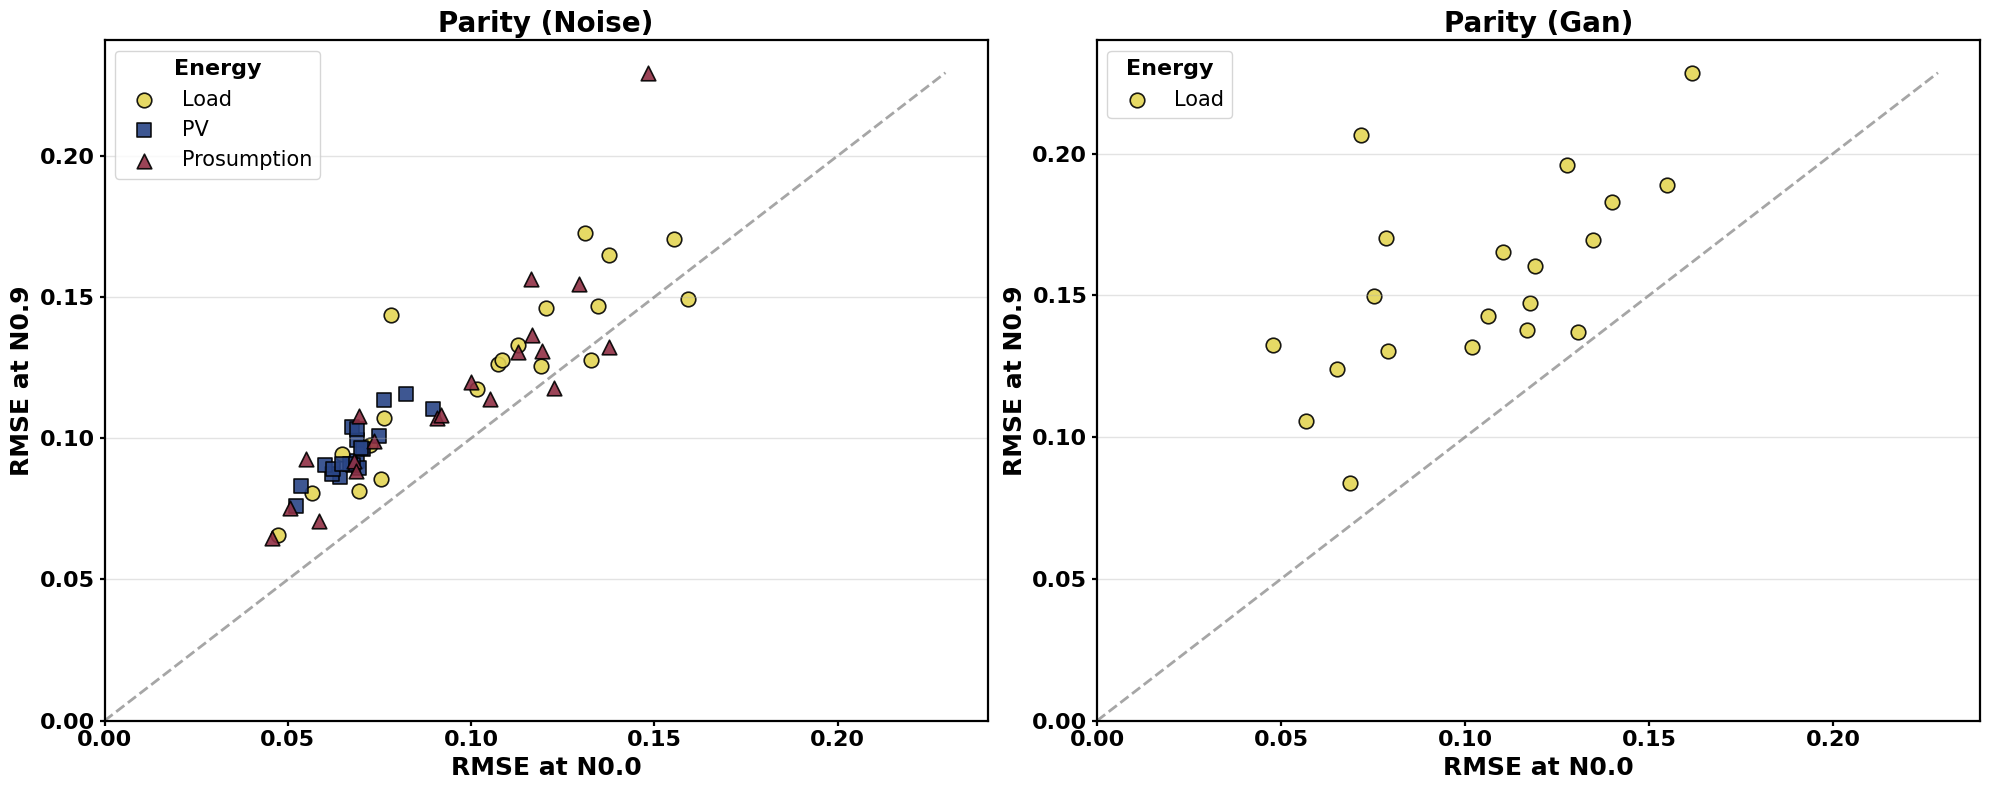

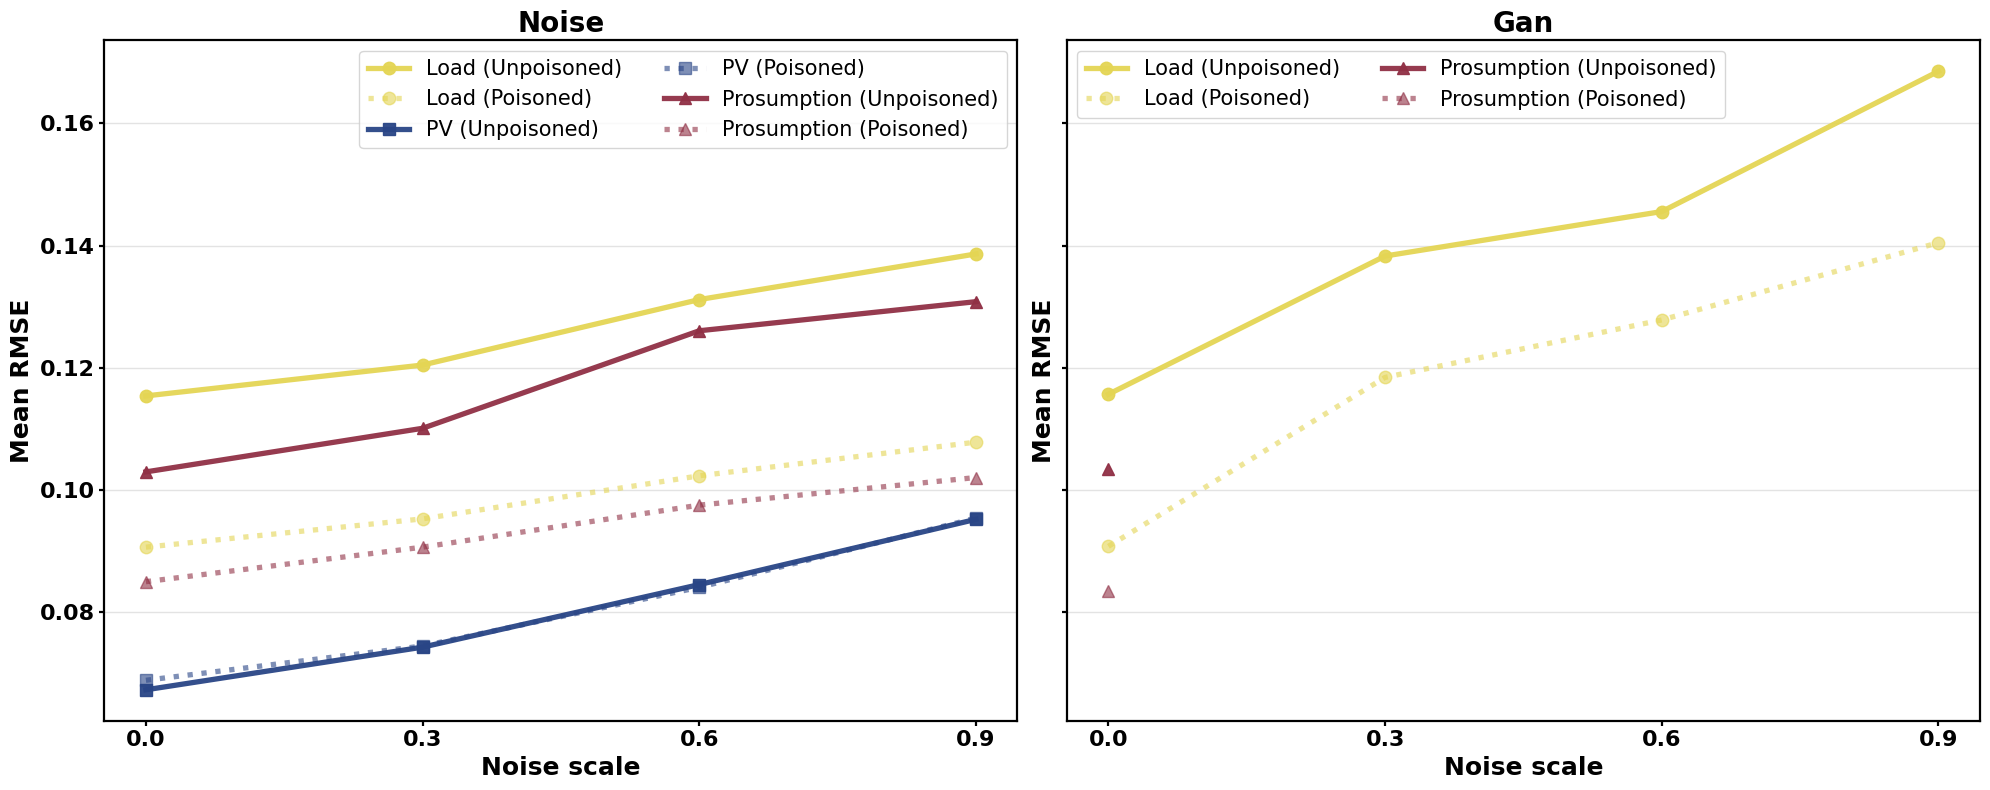

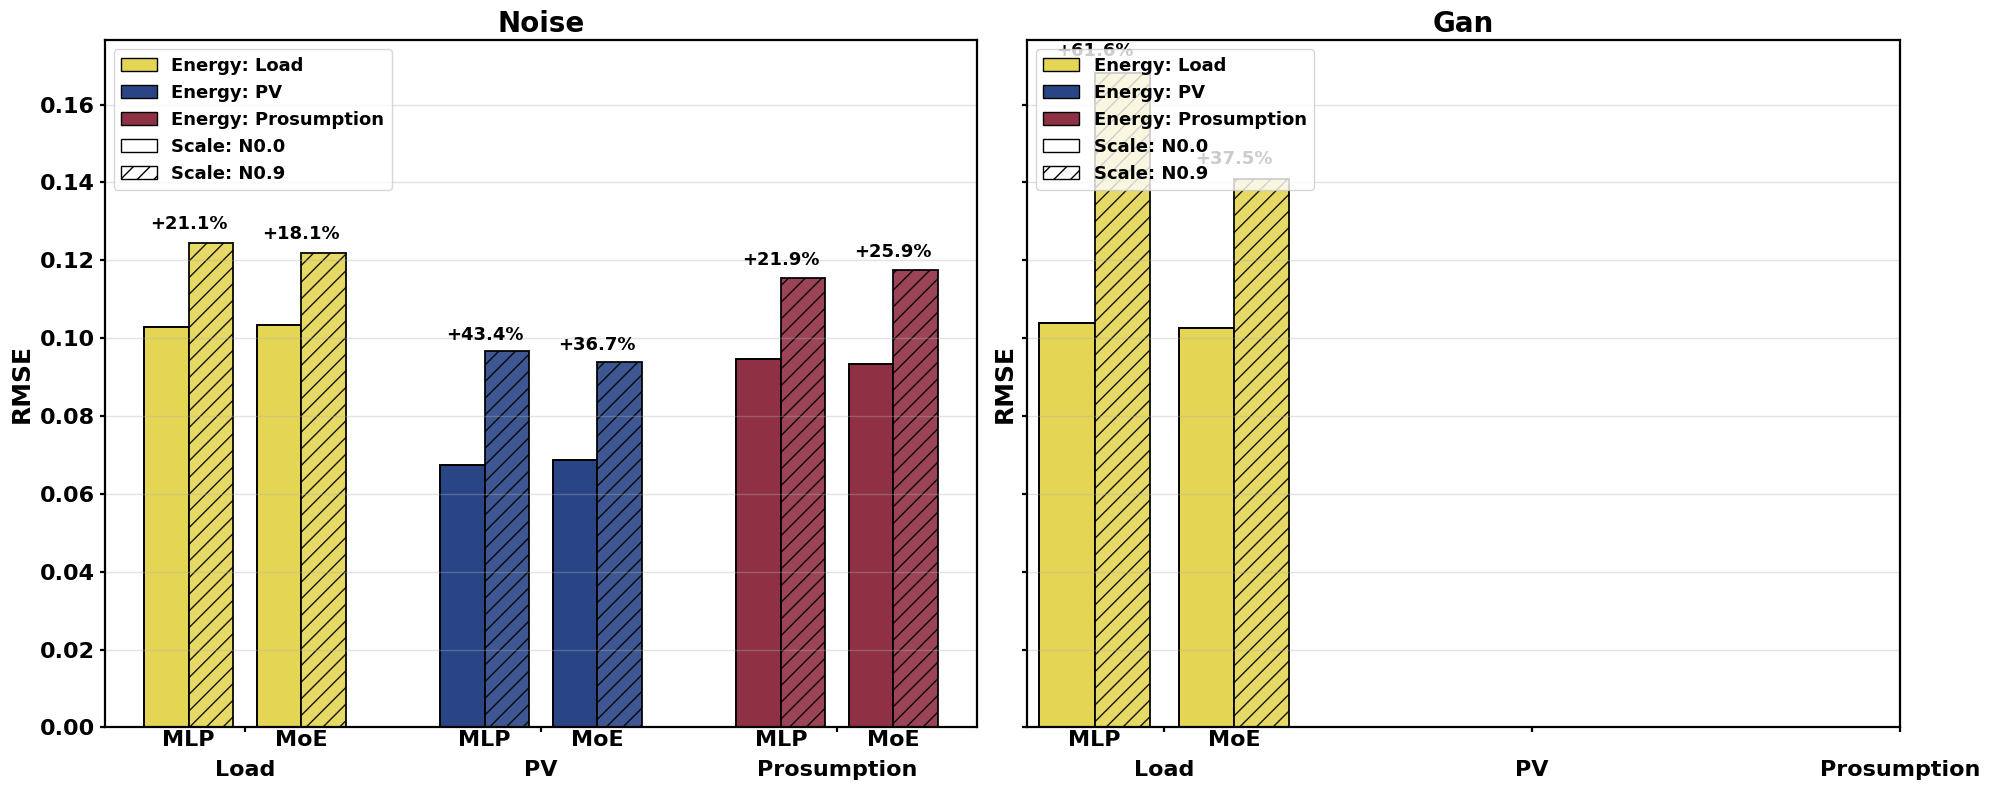

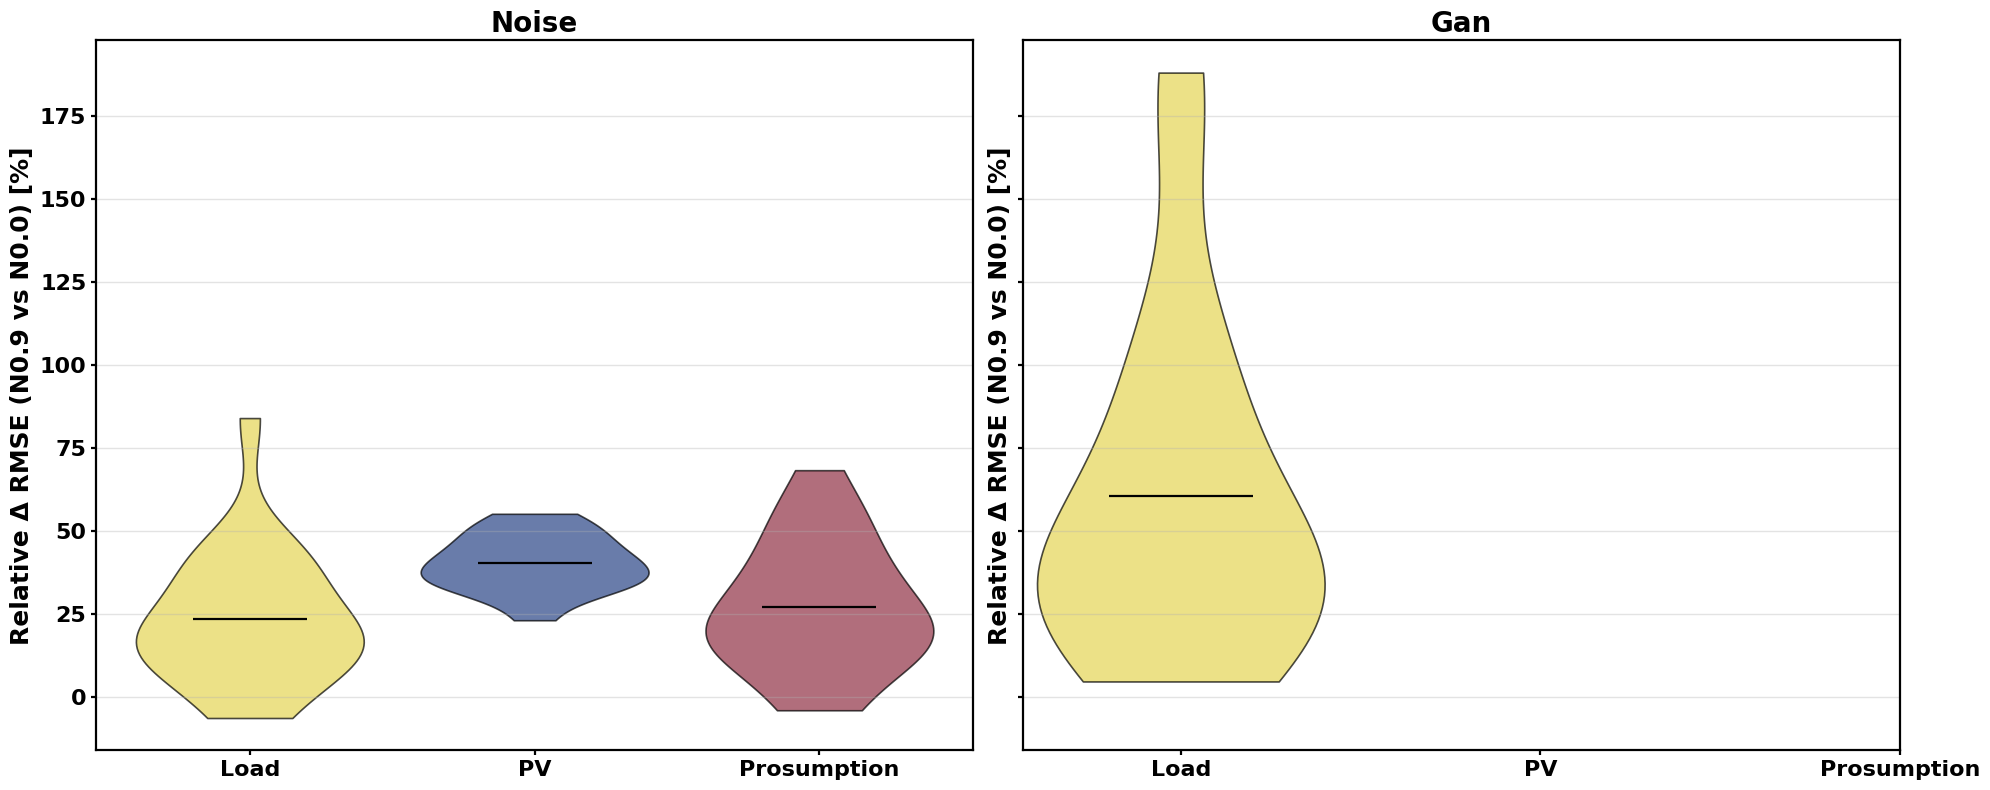

In [55]:
import os
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# -----------------------------
# Common configuration & helpers
# -----------------------------

ENERGY_MAP_DEFAULT = {"Load": 91, "PV": 92, "Prosumption": 93}
# Consistent colors across all figures
ENERGY_COLORS = {"Load": "#E4D554", "PV": "#294586", "Prosumption": "#903045"}
ENERGY_MARKERS = {"Load": "o", "PV": "s", "Prosumption": "^"}

def _scale_token(x: float) -> str:
    return f"{x:.1f}".replace(".", "p")

def _mid_for(source: str) -> str:
    return "NoiseScale" if source == "noise" else "GanScale"

def _poison_path(results_dir: str, eid: int, energy: str, source: str, scale: float) -> str:
    # Attack baseline (no security measures)
    return os.path.join(
        results_dir,
        f"{eid}{energy}_Poison_{_mid_for(source)}_{_scale_token(scale)}_Attack_all_results.csv"
    )

def _normalize_arch(col: pd.Series) -> pd.Series:
    s = col.astype(str).str.strip().str.lower()
    return np.where(s.str.contains("soft"), "SoftDenseMoE", "MLP")

def _poison_mask(df: pd.DataFrame) -> pd.Series:
    """Identify poisoned users robustly using building (+ user_key if available)."""
    b = df.get("building")
    p_b = df.get("poisoned_building")
    if b is None or p_b is None:
        return pd.Series(False, index=df.index)
    p_u_col = next((c for c in ["poisoned_user_key", "poisoned_user"] if c in df.columns), None)
    if p_u_col and ("user_key" in df.columns):
        lhs = b.astype(str).str.strip() + "||" + df["user_key"].astype(str).str.strip()
        rhs = df["poisoned_building"].astype(str).str.strip() + "||" + df[p_u_col].astype(str).str.strip()
        return lhs == rhs
    return b.astype(str).str.strip() == p_b.astype(str).str.strip()

def _read_poison_df(results_dir: str, energy: str, eid: int, source: str, scale: float, metric: str):
    path = _poison_path(results_dir, eid, energy, source, scale)
    if not os.path.exists(path):
        return None
    df = pd.read_csv(path)
    if metric not in df.columns:
        return None
    df["arch_norm"] = _normalize_arch(df["architecture"]) if "architecture" in df.columns else "MLP"
    df["building"] = df["building"].astype(str).str.strip()
    df["is_poisoned"] = _poison_mask(df)
    return df

def _per_building_arch_mean(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    """Mean metric per (building, arch)."""
    if df is None or df.empty:
        return pd.DataFrame(columns=["building", "arch_norm", "m"])
    g = (df.groupby(["building", "arch_norm"], as_index=False)[metric]
           .mean()
           .rename(columns={metric: "m"}))
    return g

def _per_building_mean_over_arch(g: pd.DataFrame) -> pd.DataFrame:
    """Mean across architectures for each building (equal weight per arch)."""
    if g is None or g.empty:
        return pd.DataFrame(columns=["building", "m_building"])
    b = (g.groupby("building", as_index=False)["m"].mean()
           .rename(columns={"m": "m_building"}))
    return b

def _overall_mean_equal_building_arch(df: pd.DataFrame, metric: str, mask: np.ndarray) -> float:
    """Overall mean with equal weight per (building, arch) for a given mask (poisoned/unpoisoned)."""
    if df is None or df.empty:
        return np.nan
    sub = df.loc[mask]
    if sub.empty:
        return np.nan
    g = _per_building_arch_mean(sub, metric)
    return float(g["m"].mean()) if not g.empty else np.nan

def _apply_journal_style(ax):
    ax.grid(True, axis="y", linewidth=1.0, alpha=0.35)
    for spine in ax.spines.values():
        spine.set_linewidth(1.6)
    ax.tick_params(axis='both', which='both', labelsize=16, width=1.6)
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontweight('bold')

# ==================================================
# 1) Parity plot: metric at 0.9 vs 0.0 (Noise | GAN)
# ==================================================
def plot_dp_parity(
    results_dir="results3",
    energy_map=ENERGY_MAP_DEFAULT,
    metric="rmse",             # default per request
):
    """
    Parity plot of metric at 0.9 vs 0.0 for each building.
    Two subplots: [Noise | GAN]. Colors = energy; markers = energy shapes.
    Figure size = (20, 8). Large, bold ticks/labels/legend.
    """
    metric = metric.lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be 'mse', 'rmse', or 'mae'")

    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=False, sharey=False)
    for ax, source in zip(axes, ["noise", "gan"]):
        # gather per-building pairs for all energies
        pairs = []
        for energy, eid in energy_map.items():
            df0 = _read_poison_df(results_dir, energy, eid, source, 0.0, metric)
            df9 = _read_poison_df(results_dir, energy, eid, source, 0.9, metric)
            if df0 is None or df9 is None or df0.empty or df9.empty:
                continue
            g0 = _per_building_mean_over_arch(_per_building_arch_mean(df0, metric)).rename(columns={"m_building": "m0"})
            g9 = _per_building_mean_over_arch(_per_building_arch_mean(df9, metric)).rename(columns={"m_building": "m9"})
            m = pd.merge(g0, g9, on="building", how="inner")
            if m.empty:
                continue
            m["energy"] = energy
            pairs.append(m)

        if pairs:
            pairs_df = pd.concat(pairs, ignore_index=True)
            # plot per energy with color+marker
            for energy in energy_map.keys():
                sub = pairs_df[pairs_df["energy"] == energy]
                if sub.empty: 
                    continue
                ax.scatter(
                    sub["m0"], sub["m9"],
                    s=110, marker=ENERGY_MARKERS[energy],
                    color=ENERGY_COLORS[energy], edgecolor="black", linewidths=1.2, alpha=0.9,
                    label=energy
                )
            # parity line
            mmax = float(np.nanmax(np.r_[pairs_df["m0"].values, pairs_df["m9"].values]))
            ax.plot([0, mmax], [0, mmax], linestyle="--", linewidth=2.0, color="gray", alpha=0.7)
            ax.set_xlim(0, mmax * 1.05)
            ax.set_ylim(0, mmax * 1.05)

        ax.set_title(f"Parity ({source.capitalize()})", fontsize=20, fontweight="bold")
        ax.set_xlabel(f"{metric.upper()} at N0.0", fontsize=18, fontweight="bold")
        ax.set_ylabel(f"{metric.upper()} at N0.9", fontsize=18, fontweight="bold")
        _apply_journal_style(ax)
        leg = ax.legend(title="Energy", loc="best", fontsize=15, frameon=True)
        if leg and leg.get_title():
            leg.get_title().set_fontsize(16)
            leg.get_title().set_fontweight("bold")

    plt.tight_layout()
    plt.show()


# ===========================================================
# 2) Lines: Mean metric vs noise scale (Poisoned & Unpoisoned)
# ===========================================================
def plot_dp_noise_curves(
    results_dir="results3",
    energy_map=ENERGY_MAP_DEFAULT,
    metric="mse",
    noise_scales=(0.0, 0.3, 0.6, 0.9)
):
    """
    Two subplots [Noise | GAN], each showing mean metric vs noise scale.
    For each energy: solid = Unpoisoned, dotted (alpha=.6) = Poisoned.
    Colors: Load=#E4D554, PV=#294586, Prosumption=#903045 (same color per energy).
    """
    metric = metric.lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be 'mse', 'rmse', or 'mae'")

    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
    for ax, source in zip(axes, ["noise", "gan"]):
        for energy, eid in energy_map.items():
            xs, ys_un, ys_po = [], [], []
            for s in noise_scales:
                df = _read_poison_df(results_dir, energy, eid, source, s, metric)
                if df is None or df.empty:
                    continue
                pmask = df["is_poisoned"].values
                mean_un = _overall_mean_equal_building_arch(df, metric, ~pmask)
                mean_po = _overall_mean_equal_building_arch(df, metric, pmask)
                xs.append(s); ys_un.append(mean_un); ys_po.append(mean_po)
            if xs:
                ax.plot(xs, ys_un,
                        linestyle="-", linewidth=3.8, marker=ENERGY_MARKERS[energy], markersize=9,
                        color=ENERGY_COLORS[energy], alpha=0.95, label=f"{energy} (Unpoisoned)")
                ax.plot(xs, ys_po,
                        linestyle=":", linewidth=3.8, marker=ENERGY_MARKERS[energy], markersize=9,
                        color=ENERGY_COLORS[energy], alpha=0.6, label=f"{energy} (Poisoned)")
        ax.set_xlabel("Noise scale", fontsize=18, fontweight="bold")
        ax.set_ylabel(f"Mean {metric.upper()}", fontsize=18, fontweight="bold")
        ax.set_title(f"{source.capitalize()}", fontsize=20, fontweight="bold")
        ax.set_xticks(list(noise_scales))
        _apply_journal_style(ax)
        leg = ax.legend(loc="best", fontsize=15, ncols=2, frameon=True)
        if leg and leg.get_title():
            leg.get_title().set_fontsize(16)
            leg.get_title().set_fontweight("bold")
    plt.tight_layout()
    plt.show()


# ==========================================================================================
# 3) Bars: metric per neural network (MLP / SoftDenseMoE) at scales 0.0 vs 0.9 (Noise | GAN)
# ==========================================================================================
def plot_dp_arch_bars_0_vs_9(
    results_dir="results3",
    energy_map=ENERGY_MAP_DEFAULT,
    metric="mse"
):
    """
    Two subplots [Noise | GAN]. Groups = energy types.
    Within each group, show two small clusters (MLP, SoftDenseMoE); each cluster has two bars (N0.0, N0.9).
    Bars use the energy color; N0.9 is hatched. Above each cluster, annotate % increase from 0.0 to 0.9.
    Shows model names (MLP / SoftDenseMoE) as minor x-axis tick labels beneath each cluster.
    Single legend (upper left) combining energy colors + scale info.
    """
    metric = metric.lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be 'mse', 'rmse', or 'mae'")

    def per_arch_mean(df):
        # equal weight per (building, arch)
        g = _per_building_arch_mean(df, metric)
        return g.groupby("arch_norm")["m"].mean()

    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
    archs = ["MLP", "SoftDenseMoE"]
    x_groups = np.arange(len(energy_map))  # group centers (per energy)
    width_cluster = 0.38   # spacing between MLP and Soft inside a group
    bar_width = 0.15       # width of each bar (0.0 and 0.9)

    for ax, source in zip(axes, ["noise", "gan"]):
        # track minor tick positions/labels for models
        minor_pos, minor_labels = [], []

        for gi, (energy, eid) in enumerate(energy_map.items()):
            # read 0.0 & 0.9
            d0 = _read_poison_df(results_dir, energy, eid, source, 0.0, metric)
            d9 = _read_poison_df(results_dir, energy, eid, source, 0.9, metric)
            if d0 is None or d9 is None or d0.empty or d9.empty:
                continue
            m0 = per_arch_mean(d0); m9 = per_arch_mean(d9)

            # plot small cluster for each arch (two bars: 0.0 & 0.9)
            for ai, arch in enumerate(archs):
                x_center = x_groups[gi] + (ai - 0.5) * width_cluster
                y0 = float(m0.get(arch, np.nan))
                y9 = float(m9.get(arch, np.nan))
                # bars (0.0 left, 0.9 right)
                ax.bar(x_center - bar_width/2, y0, width=bar_width,
                       color=ENERGY_COLORS[energy], edgecolor="black", linewidth=1.4)
                ax.bar(x_center + bar_width/2, y9, width=bar_width,
                       color=ENERGY_COLORS[energy], edgecolor="black", linewidth=1.4,
                       hatch="//", alpha=0.9)
                # annotate % increase
                if np.isfinite(y0) and y0 != 0 and np.isfinite(y9):
                    pct = (y9 - y0) / y0 * 100.0
                    ax.text(x_center, max(y0, y9) * 1.02, f"{pct:+.1f}%", ha="center",
                            va="bottom", fontsize=13, fontweight="bold")
                # minor tick for model name
                minor_pos.append(x_center)
                minor_labels.append("MLP" if arch == "MLP" else "MoE")

        # major ticks = energy groups
        ax.set_xticks(x_groups)
        ax.set_xticklabels(list(energy_map.keys()), fontsize=16, fontweight="bold")
        # major (energy) ticks lower
        ax.tick_params(axis='x', which='major', pad=20)
        # minor ticks = model names under each cluster
        if minor_pos:
            ax.set_xticks(minor_pos, minor=True)
            ax.set_xticklabels(minor_labels, minor=True, fontsize=12, fontweight="bold", rotation=0)
            ax.tick_params(axis='x', which='minor', pad=2, length=0)

        ax.set_ylabel(metric.upper(), fontsize=18, fontweight="bold")
        ax.set_title(f"{source.capitalize()}", fontsize=20, fontweight="bold")
        _apply_journal_style(ax)

        # SINGLE legend (upper left): energy colors + scale entries
        energy_handles = [Patch(facecolor=ENERGY_COLORS[e], edgecolor="black", label=f"Energy: {e}")
                          for e in energy_map.keys()]
        scale_handles = [
            Patch(facecolor="white", edgecolor="black", label="Scale: N0.0"),
            Patch(facecolor="white", edgecolor="black", hatch="//", label="Scale: N0.9")
        ]
        handles = energy_handles + scale_handles
        leg = ax.legend(handles=handles, loc="upper left", fontsize=13, frameon=True)
        if leg:
            for txt in leg.get_texts():
                txt.set_fontweight('bold')

    plt.tight_layout()
    plt.show()


# ===========================================================================
# 4) Violins: per-building relative change (N0.9 vs N0.0) — 3 violins/energy
# (with safe handling of empty datasets)
# ===========================================================================
def plot_dp_relative_violins(
    results_dir="results3",
    energy_map=ENERGY_MAP_DEFAULT,
    metric="mse"
):
    """
    Two subplots [Noise | GAN]. Each subplot shows up to three violins (Load, PV, Prosumption)
    of per-building relative change (%) from N0.0 to N0.9.
    Empty datasets are skipped gracefully (no error, axis still labeled).
    """
    metric = metric.lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be 'mse', 'rmse', or 'mae'")

    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

    for ax, source in zip(axes, ["noise", "gan"]):
        # Prepare per-energy arrays of relative deltas
        all_labels = list(energy_map.keys())
        per_energy_arrays = []
        for energy, eid in energy_map.items():
            df0 = _read_poison_df(results_dir, energy, eid, source, 0.0, metric)
            df9 = _read_poison_df(results_dir, energy, eid, source, 0.9, metric)

            if df0 is None or df9 is None or df0.empty or df9.empty:
                per_energy_arrays.append(np.array([]))
                continue

            g0 = _per_building_mean_over_arch(_per_building_arch_mean(df0, metric)).rename(columns={"m_building":"m0"})
            g9 = _per_building_mean_over_arch(_per_building_arch_mean(df9, metric)).rename(columns={"m_building":"m9"})
            m = pd.merge(g0, g9, on="building", how="inner")
            if m.empty:
                per_energy_arrays.append(np.array([]))
                continue

            rel = np.where(m["m0"] > 0, (m["m9"] - m["m0"]) / m["m0"] * 100.0, np.nan)
            rel = rel[np.isfinite(rel)]  # drop NaN/inf
            per_energy_arrays.append(rel)

        # Draw only non-empty violins, at the correct positions
        positions = [i + 1 for i, arr in enumerate(per_energy_arrays) if arr.size > 0]
        datasets  = [arr for arr in per_energy_arrays if arr.size > 0]
        labels_for_datasets = [all_labels[i - 1] for i in positions]

        if datasets:
            parts = ax.violinplot(datasets, positions=positions, showmeans=True,
                                  showextrema=False, widths=0.8)
            # Color each body by its energy label
            for body, energy in zip(parts['bodies'], labels_for_datasets):
                body.set_facecolor(ENERGY_COLORS[energy])
                body.set_edgecolor("black")
                body.set_alpha(0.7)
                body.set_linewidth(1.2)
            parts['cmeans'].set_edgecolor("black")
            parts['cmeans'].set_linewidth(1.6)

        # Always show all three energy labels on the x-axis
        ax.set_xticks(np.arange(1, len(all_labels) + 1))
        ax.set_xticklabels(all_labels, fontsize=16, fontweight="bold")

        ax.set_ylabel(f"Relative Δ {metric.upper()} (N0.9 vs N0.0) [%]", fontsize=18, fontweight="bold")
        ax.set_title(f"{source.capitalize()}", fontsize=20, fontweight="bold")
        _apply_journal_style(ax)

    plt.tight_layout()
    plt.show()

# 1) Parity (default metric = RMSE)
plot_dp_parity(metric="rmse")        # or "mse" / "mae"

# 2) Mean metric vs noise (Poisoned dotted, Unpoisoned solid)
plot_dp_noise_curves(metric="rmse")

# 3) Bars per architecture at N0.0 vs N0.9 with % increases
plot_dp_arch_bars_0_vs_9(metric="rmse")

# 4) Violins of per-building relative change (N0.9 vs N0.0)
plot_dp_relative_violins(metric="rmse")


### Data Backdoor - GAN vs Noise

In [32]:
# Backdoor Overview — Load, PV, Prosumption (metric split into Poisoned vs Unpoisoned Hours)

import os
import numpy as np
import pandas as pd
import re

def summarize_backdoor_results(
    results_dir="results3",
    energy_map={"Load": 91, "PV": 92, "Prosumption": 93},
    scales=(0.0, 0.3, 0.6, 0.9),
    attack_source="noise",           # "noise" | "gan"
    metric="mse",                    # "mse" | "rmse" | "mae"
    label_prefix="N",                # keep "N" even for GAN (as requested)
    backdoor_start_time="10:30",     # HH:MM (default from your setup)
    backdoor_num_steps=4,            # default from your setup
):
    """
    Build summary tables for Backdoor experiments where only some hours are poisoned.

    Rows:    ["LL", "N0.0", "N0.3", "N0.6", "N0.9"]  (prefix always "N")
    Columns: (per selected metric, name adapts to MSE/RMSE/MAE)
        - Unpoisoned Hours: Mean <MET>
        - Unpoisoned Hours: <MET> MLP
        - Unpoisoned Hours: <MET> SoftDenseMoE
        - Poisoned Hours:   Mean <MET>
        - Poisoned Hours:   <MET> MLP
        - Poisoned Hours:   <MET> SoftDenseMoE
        - Δ% vs N0.0 (Unpoisoned Hours)
        - Δ% vs N0.0 (Poisoned Hours)

    Aggregation is fair:
        1) per (ID, architecture, hour) average of the metric
           - ID is 'building' if present; else 'user'; else 'cluster_id'; else all rows treated as one ID
        2) within each hour set (poisoned/unpoisoned): average across hours for each (ID, arch)
        3) overall = mean of those (ID, arch) values (equal weight per ID and architecture)
        4) per-arch = mean across IDs within each architecture
    """
    metric = str(metric).lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be one of: 'mse', 'rmse', 'mae'")

    attack_source = str(attack_source).lower().strip()
    if attack_source not in {"noise", "gan"}:
        raise ValueError("attack_source must be 'noise' or 'gan'")

    MET = metric.upper()
    mid = "NoiseScale" if attack_source == "noise" else "GanScale"

    def scale_to_token(x: float) -> str:
        return f"{x:.1f}".replace(".", "p")

    def make_backdoor_path(energy: str, eid: int, scale: float) -> str:
        token = scale_to_token(scale)
        fname = f"{eid}{energy}_Backdoor_{mid}_{token}_Attack_per_hour_results.csv"
        return os.path.join(results_dir, fname)

    # ---------------- poisoned-hour window ----------------
    def _parse_hhmm_to_hour_start(hhmm: str | None) -> int:
        # '10:30' -> 10 ; fallback to 10 if None/bad
        if not hhmm or not isinstance(hhmm, str):
            return 10
        m = re.match(r"^\s*(\d{1,2})(?::(\d{1,2}))?\s*$", hhmm)
        if not m:
            return 10
        h = int(m.group(1))
        # minutes are ignored (floor to hour)
        return max(0, min(23, h))

    def poisoned_hours_set(start_time_str: str, steps: int) -> set:
        h0 = _parse_hhmm_to_hour_start(start_time_str)
        return { (h0 + k) % 24 for k in range(int(steps)) }

    POISONED_HOURS = poisoned_hours_set(backdoor_start_time, backdoor_num_steps)

    # ---------------- helpers ----------------
    def _normalize_arch(col: pd.Series) -> pd.Series:
        s = col.astype(str).str.strip().str.lower()
        return np.where(s.str.contains("soft"), "SoftDenseMoE", "MLP")

    def _select_id_col(df: pd.DataFrame) -> str:
        for cand in ["building", "user_key", "user", "cluster_id"]:
            if cand in df.columns:
                return cand
        # last resort: create a fake single-ID column
        df["_single_id"] = "ALL"
        return "_single_id"

    def _read_if_exists(path: str) -> pd.DataFrame | None:
        if not os.path.exists(path):
            return None
        df = pd.read_csv(path)
        if metric not in df.columns or "hour" not in df.columns:
            return None
        # normalize
        if "architecture" in df.columns:
            df["arch_norm"] = _normalize_arch(df["architecture"])
        else:
            df["arch_norm"] = "MLP"
        df["hour"] = pd.to_numeric(df["hour"], errors="coerce").astype("Int64")
        # choose an ID column (building preferred)
        id_col = _select_id_col(df)
        df[id_col] = df[id_col].astype(str).str.strip()
        df["_id_col"] = id_col  # remember which one we picked
        # poisoned hour flag
        df["is_poisoned_hour"] = df["hour"].astype(float).isin(list(POISONED_HOURS))
        return df

    def _aggregate_split_by_hours(df: pd.DataFrame) -> dict:
        """
        Return a block of 6 values per metric group:
          Unpoisoned Hours: Mean/MLP/Soft ; Poisoned Hours: Mean/MLP/Soft
        """
        cols_out = [
            f"Unpoisoned Hours: Mean {MET}",
            f"Unpoisoned Hours: {MET} MLP",
            f"Unpoisoned Hours: {MET} SoftDenseMoE",
            f"Poisoned Hours: Mean {MET}",
            f"Poisoned Hours: {MET} MLP",
            f"Poisoned Hours: {MET} SoftDenseMoE",
        ]
        if df is None or df.empty:
            return {k: np.nan for k in cols_out}

        id_col = df["_id_col"].iloc[0]
        tmp = df.copy()

        # 1) per (ID, arch, hour) average
        step1 = (tmp
                 .groupby([id_col, "arch_norm", "hour"], as_index=False)[metric]
                 .mean()
                 .rename(columns={metric: "m_hour"}))

        # 2) per (ID, arch, is_poisoned_hour) mean across hours (equal weight per hour within bucket)
        step1["is_poisoned_hour"] = step1["hour"].astype(float).isin(list(POISONED_HOURS))
        step2 = (step1
                 .groupby([id_col, "arch_norm", "is_poisoned_hour"], as_index=False)["m_hour"]
                 .mean()
                 .rename(columns={"m_hour": "m_id_arch_bucket"}))

        # helper to compute overall & per-arch from a bucket
        def bucket_stats(is_poisoned: bool) -> tuple[float, float, float]:
            sub = step2.loc[step2["is_poisoned_hour"] == is_poisoned]
            if sub.empty:
                return (np.nan, np.nan, np.nan)
            # overall mean: equal weight per (ID, arch)
            overall = sub["m_id_arch_bucket"].mean()
            # per-arch mean: equal weight per ID
            mlp = (sub.loc[sub["arch_norm"] == "MLP", "m_id_arch_bucket"].mean()
                   if (sub["arch_norm"] == "MLP").any() else np.nan)
            soft = (sub.loc[sub["arch_norm"] == "SoftDenseMoE", "m_id_arch_bucket"].mean()
                    if (sub["arch_norm"] == "SoftDenseMoE").any() else np.nan)
            return (overall, mlp, soft)

        un_mean, un_mlp, un_soft = bucket_stats(False)
        po_mean, po_mlp, po_soft = bucket_stats(True)

        return {
            f"Unpoisoned Hours: Mean {MET}": un_mean,
            f"Unpoisoned Hours: {MET} MLP": un_mlp,
            f"Unpoisoned Hours: {MET} SoftDenseMoE": un_soft,
            f"Poisoned Hours: Mean {MET}": po_mean,
            f"Poisoned Hours: {MET} MLP": po_mlp,
            f"Poisoned Hours: {MET} SoftDenseMoE": po_soft,
        }

    def _one_table_for_energy(energy: str, eid: int) -> pd.DataFrame:
        row_labels = ["LL"] + [f"{label_prefix}{s:.1f}" for s in scales]
        cols = [
            f"Unpoisoned Hours: Mean {MET}",
            f"Unpoisoned Hours: {MET} MLP",
            f"Unpoisoned Hours: {MET} SoftDenseMoE",
            f"Poisoned Hours: Mean {MET}",
            f"Poisoned Hours: {MET} MLP",
            f"Poisoned Hours: {MET} SoftDenseMoE",
            f"Δ% vs N0.0 (Unpoisoned Hours)",
            f"Δ% vs N0.0 (Poisoned Hours)",
        ]
        out = pd.DataFrame(index=row_labels, columns=cols, dtype=float)

        # Fill N0.x rows
        for s in scales:
            df = _read_if_exists(make_backdoor_path(energy, eid, s))
            block = _aggregate_split_by_hours(df)
            out.loc[f"{label_prefix}{s:.1f}", cols[:6]] = block

        # Diffs vs N0.0 within each hour bucket
        base_key = f"{label_prefix}0.0"
        un_mean_col = f"Unpoisoned Hours: Mean {MET}"
        po_mean_col = f"Poisoned Hours: Mean {MET}"

        base_un = out.loc[base_key, un_mean_col] if base_key in out.index else np.nan
        base_po = out.loc[base_key, po_mean_col] if base_key in out.index else np.nan

        def pct_diff(val, base):
            if pd.isna(val) or pd.isna(base) or base == 0:
                return np.nan
            return (val - base) / base * 100.0

        for row in out.index:
            out.loc[row, "Δ% vs N0.0 (Unpoisoned Hours)"] = pct_diff(out.loc[row, un_mean_col], base_un)
            out.loc[row, "Δ% vs N0.0 (Poisoned Hours)"]   = pct_diff(out.loc[row, po_mean_col], base_po)


        # Round non-LL rows; LL to "-"
        non_ll = out.index != "LL"
        out.loc[non_ll, :] = out.loc[non_ll, :].astype(float).round(6)
        out = out.astype(object)
        out.loc["LL", :] = "-"
        return out

    return {en: _one_table_for_energy(en, eid) for en, eid in energy_map.items()}

# -------------------------- Example usage --------------------------
# Noise-based backdoor summary (metric=MSE)
backdoor_noise = summarize_backdoor_results(attack_source="noise", metric="mse")
display(backdoor_noise["Load"])          # PV/Prosumption will show NaNs until files exist

# GAN-based backdoor summary (same "N" prefix for rows, as requested)
backdoor_gan = summarize_backdoor_results(attack_source="gan", metric="mse", label_prefix="N")
display(backdoor_gan["Load"])

,Unpoisoned Hours: Mean MSE,Unpoisoned Hours: MSE MLP,Unpoisoned Hours: MSE SoftDenseMoE,Poisoned Hours: Mean MSE,Poisoned Hours: MSE MLP,Poisoned Hours: MSE SoftDenseMoE,Δ% vs N0.0 (Unpoisoned Hours),Δ% vs N0.0 (Poisoned Hours)
LL,-,-,-,-,-,-,-,-
N0.0,0.012774,0.012882,0.012667,0.005511,0.005516,0.005505,0.0,0.0
N0.3,0.012999,0.012973,0.013024,0.006478,0.006798,0.006157,1.754116,17.550509
N0.6,0.013281,0.013787,0.012776,0.007024,0.007579,0.00647,3.965685,27.4683
N0.9,0.013332,0.013791,0.012873,0.007067,0.007966,0.006168,4.362688,28.241531


,Unpoisoned Hours: Mean MSE,Unpoisoned Hours: MSE MLP,Unpoisoned Hours: MSE SoftDenseMoE,Poisoned Hours: Mean MSE,Poisoned Hours: MSE MLP,Poisoned Hours: MSE SoftDenseMoE,Δ% vs N0.0 (Unpoisoned Hours),Δ% vs N0.0 (Poisoned Hours)
LL,-,-,-,-,-,-,-,-
N0.0,0.012885,0.01287,0.012901,0.005619,0.005667,0.005571,0.0,0.0
N0.3,0.012769,0.012814,0.012724,0.006368,0.006533,0.006203,-0.903675,13.328799
N0.6,0.012856,0.013018,0.012694,0.006629,0.006933,0.006326,-0.226686,17.975964
N0.9,0.013243,0.013433,0.013053,0.007019,0.007466,0.006572,2.777956,24.915233


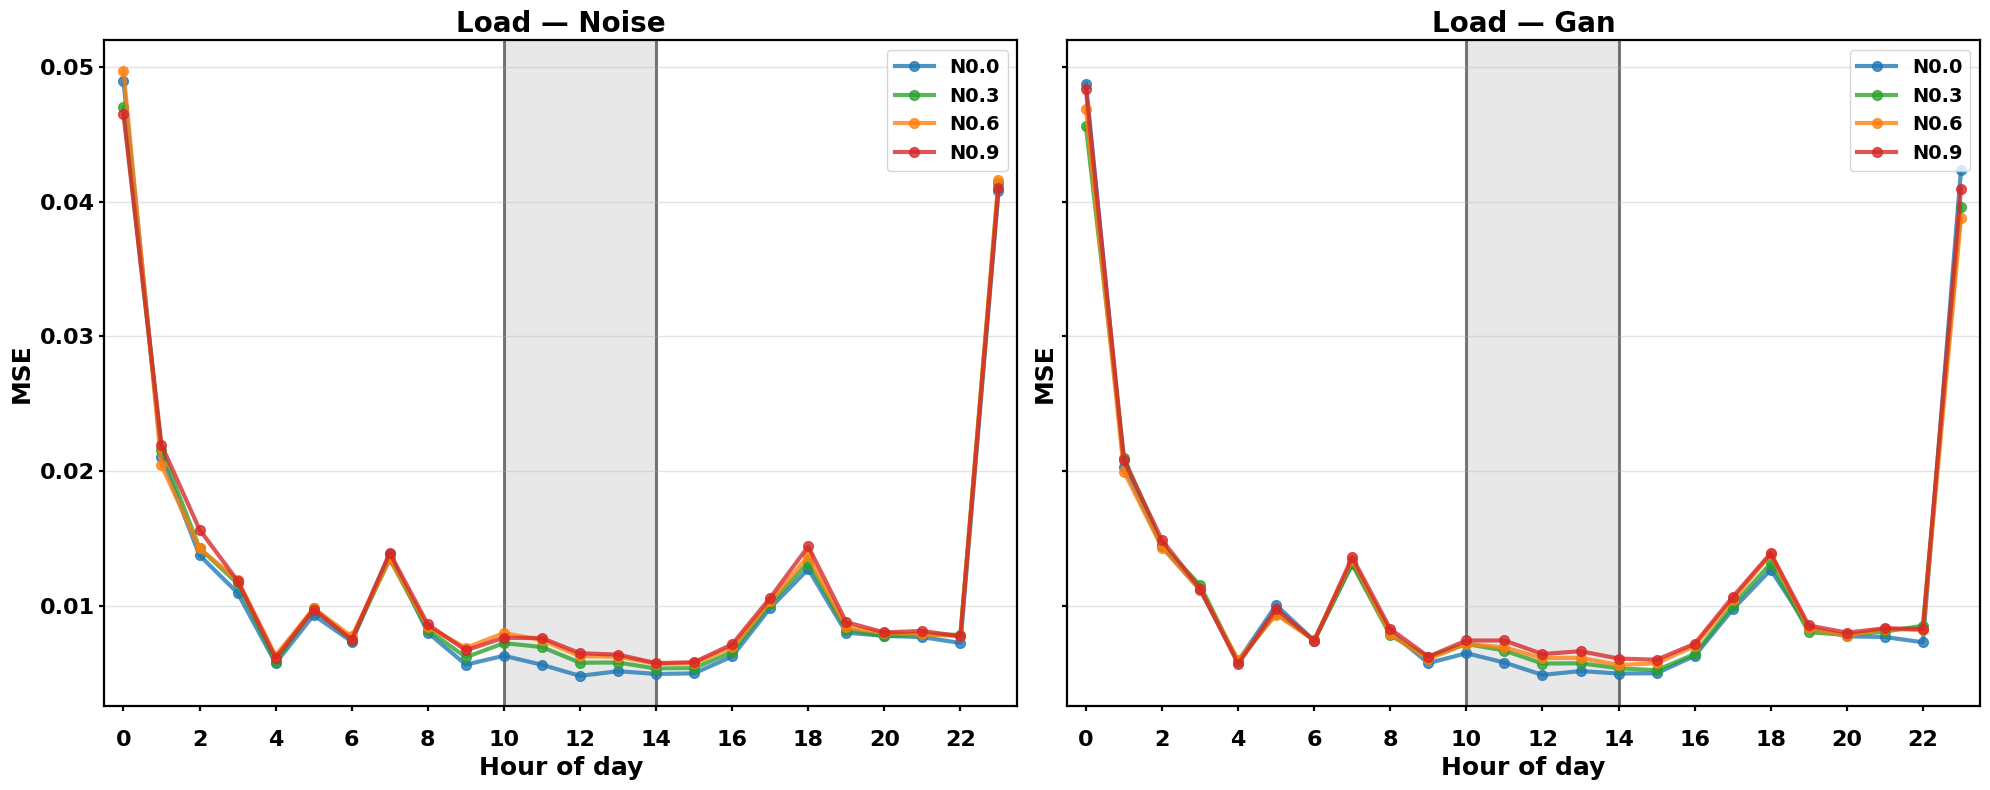

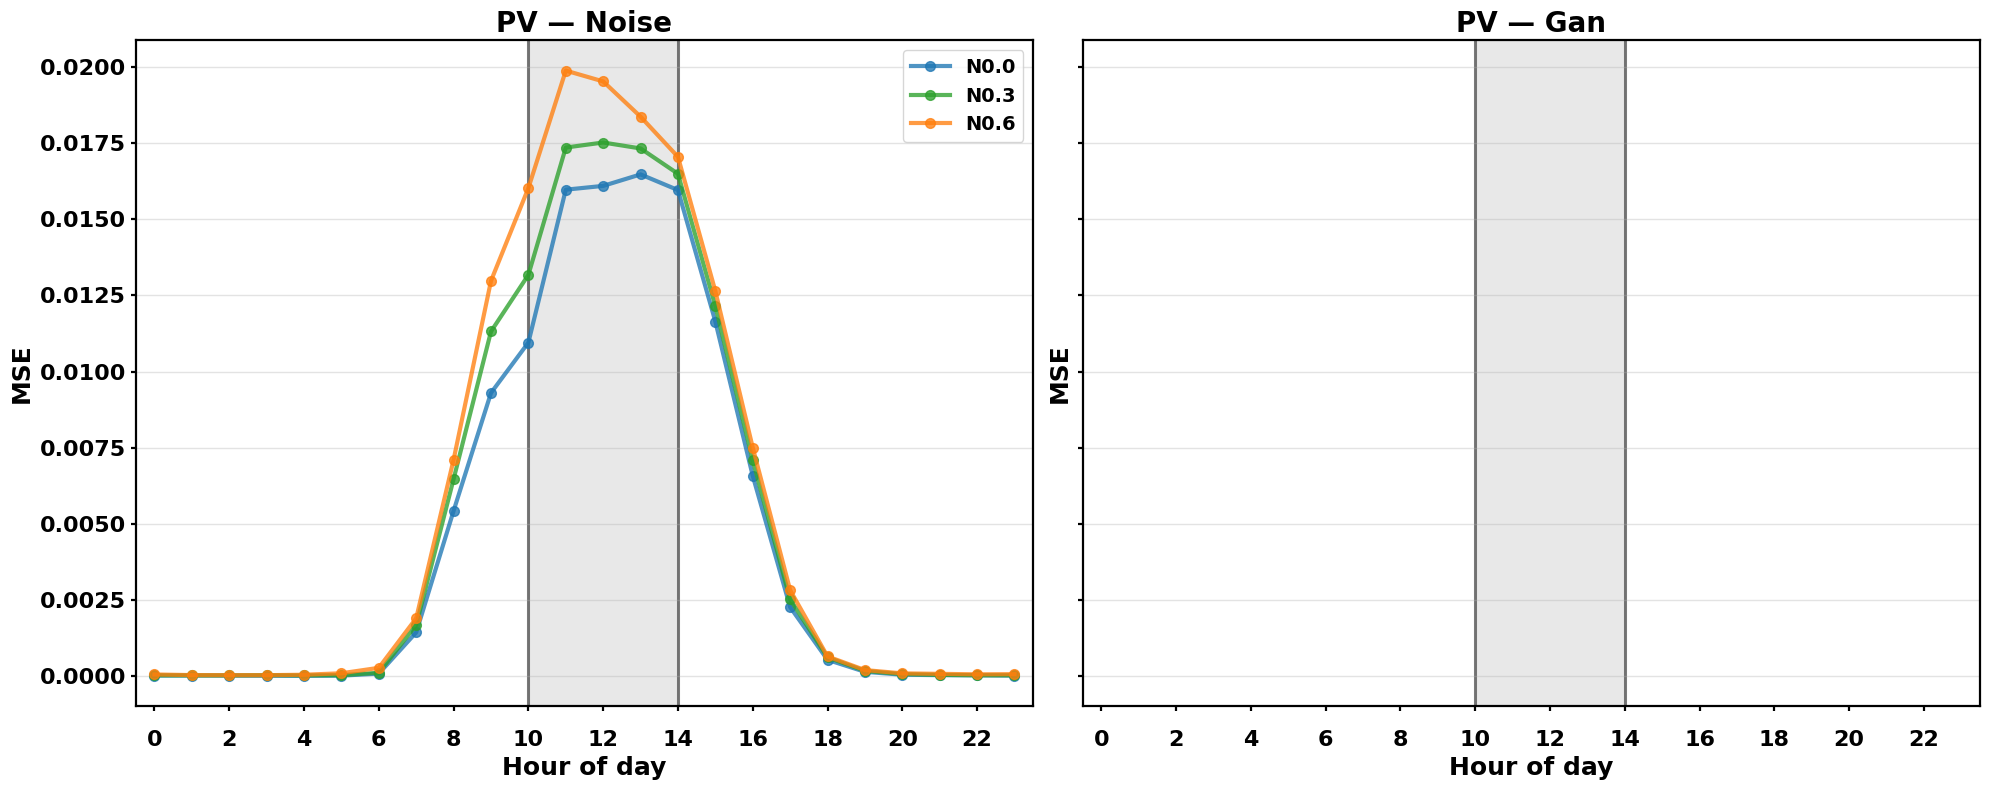

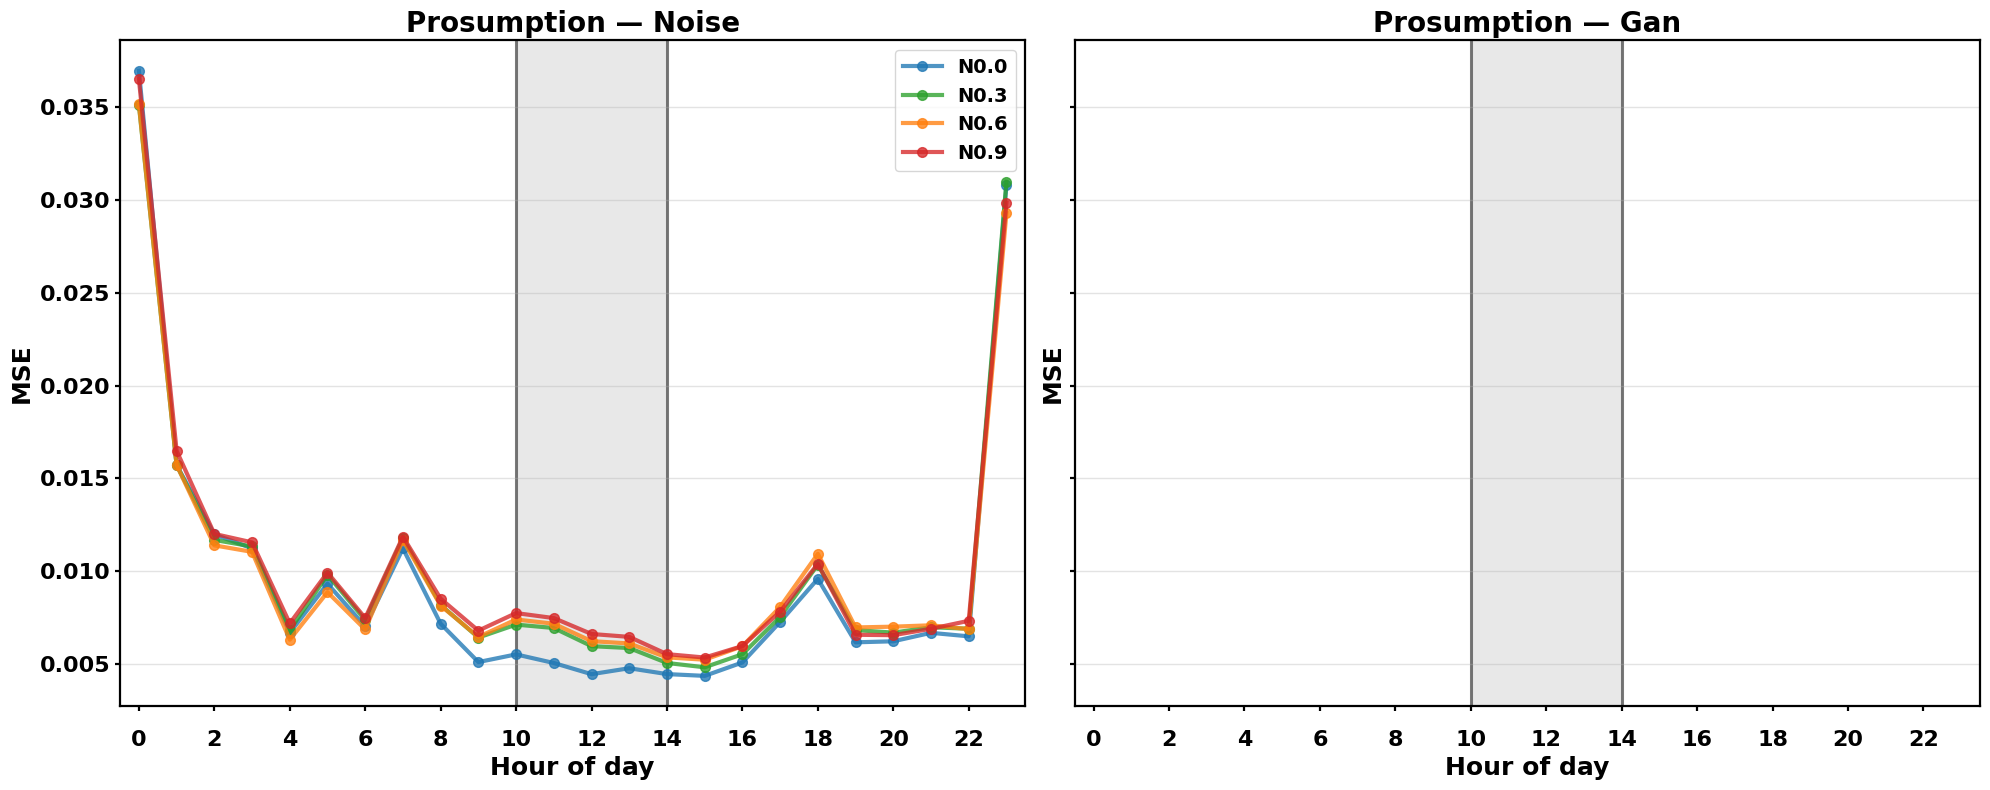

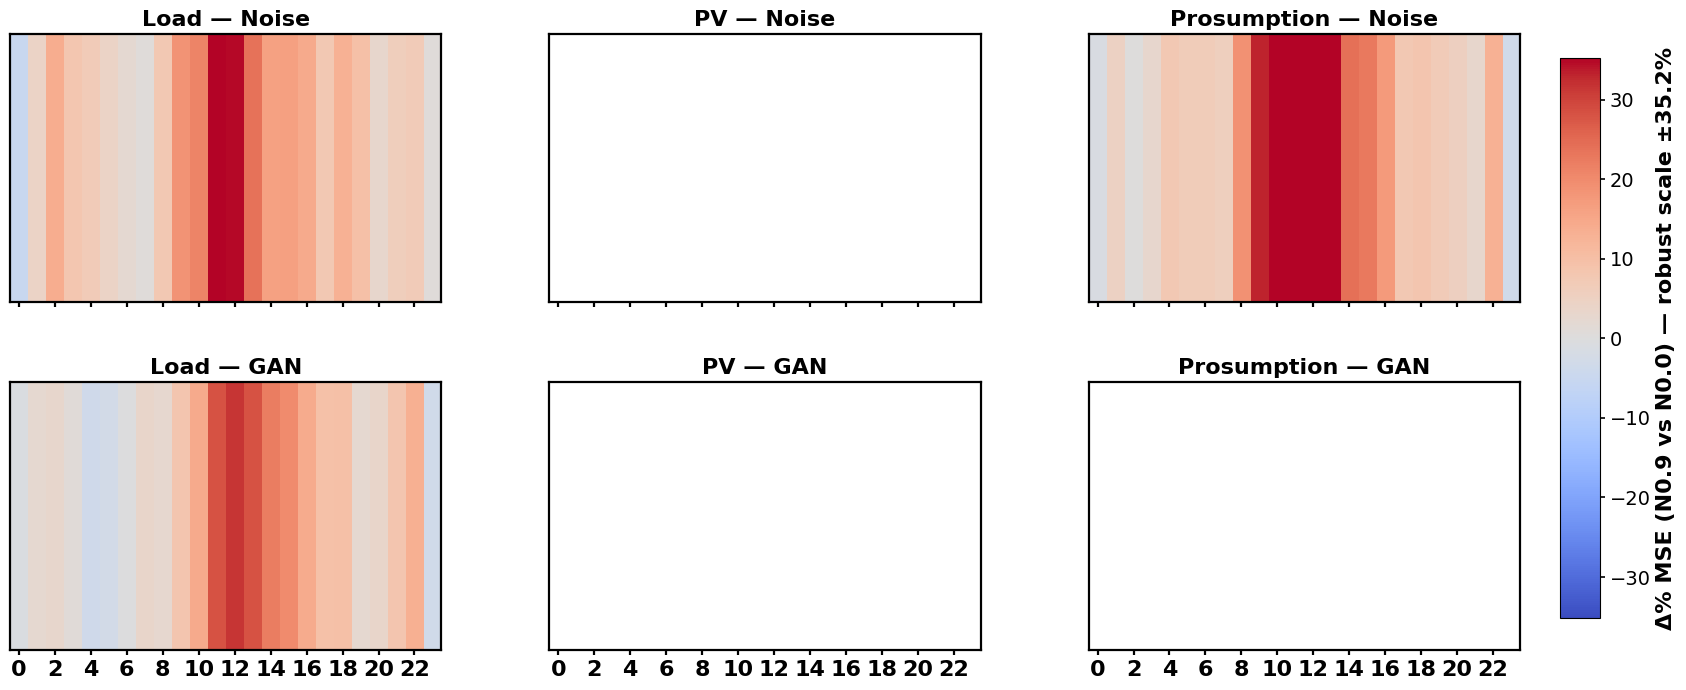


[Backdoor Violin] Source=Noise, Metric=MSE
  Load: counts per scale {'N0.0': 2, 'N0.3': 2, 'N0.6': 2, 'N0.9': 2}; pooled median=0.0061
  PV: counts per scale {'N0.0': 2, 'N0.3': 2, 'N0.6': 2, 'N0.9': 0}; pooled median=0.0163
  Prosumption: counts per scale {'N0.0': 2, 'N0.3': 2, 'N0.6': 2, 'N0.9': 2}; pooled median=0.0057

[Backdoor Violin] Source=Gan, Metric=MSE
  Load: counts per scale {'N0.0': 2, 'N0.3': 2, 'N0.6': 2, 'N0.9': 2}; pooled median=0.0063
  PV: no data for any scale
  Prosumption: no data for any scale


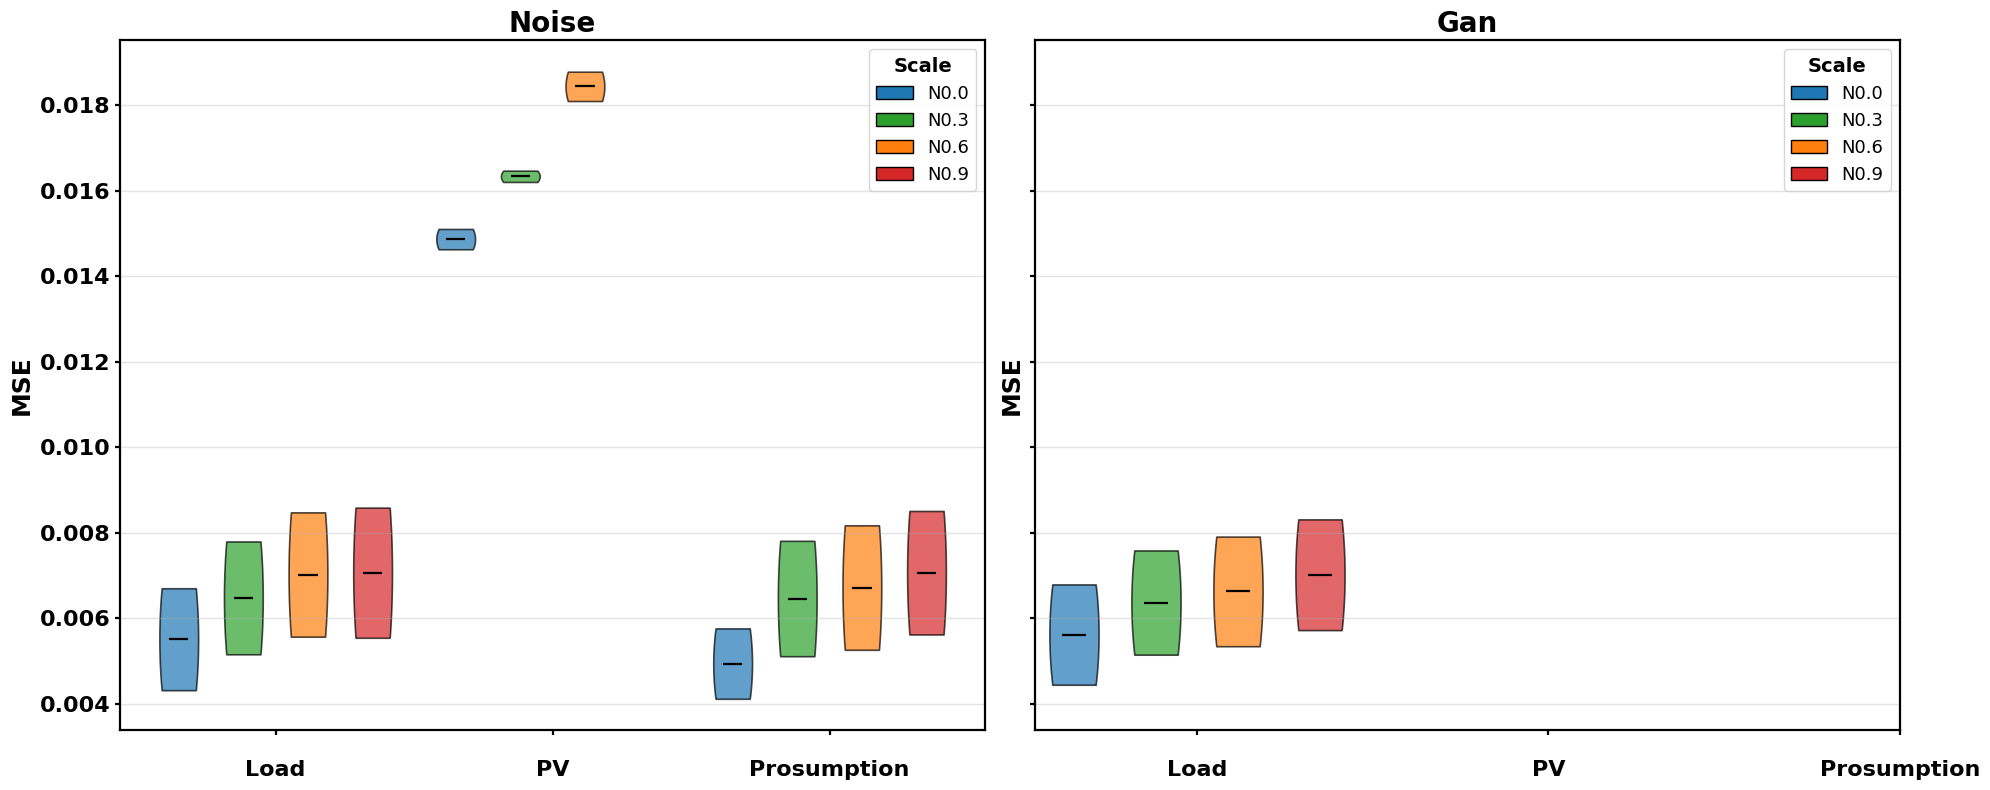

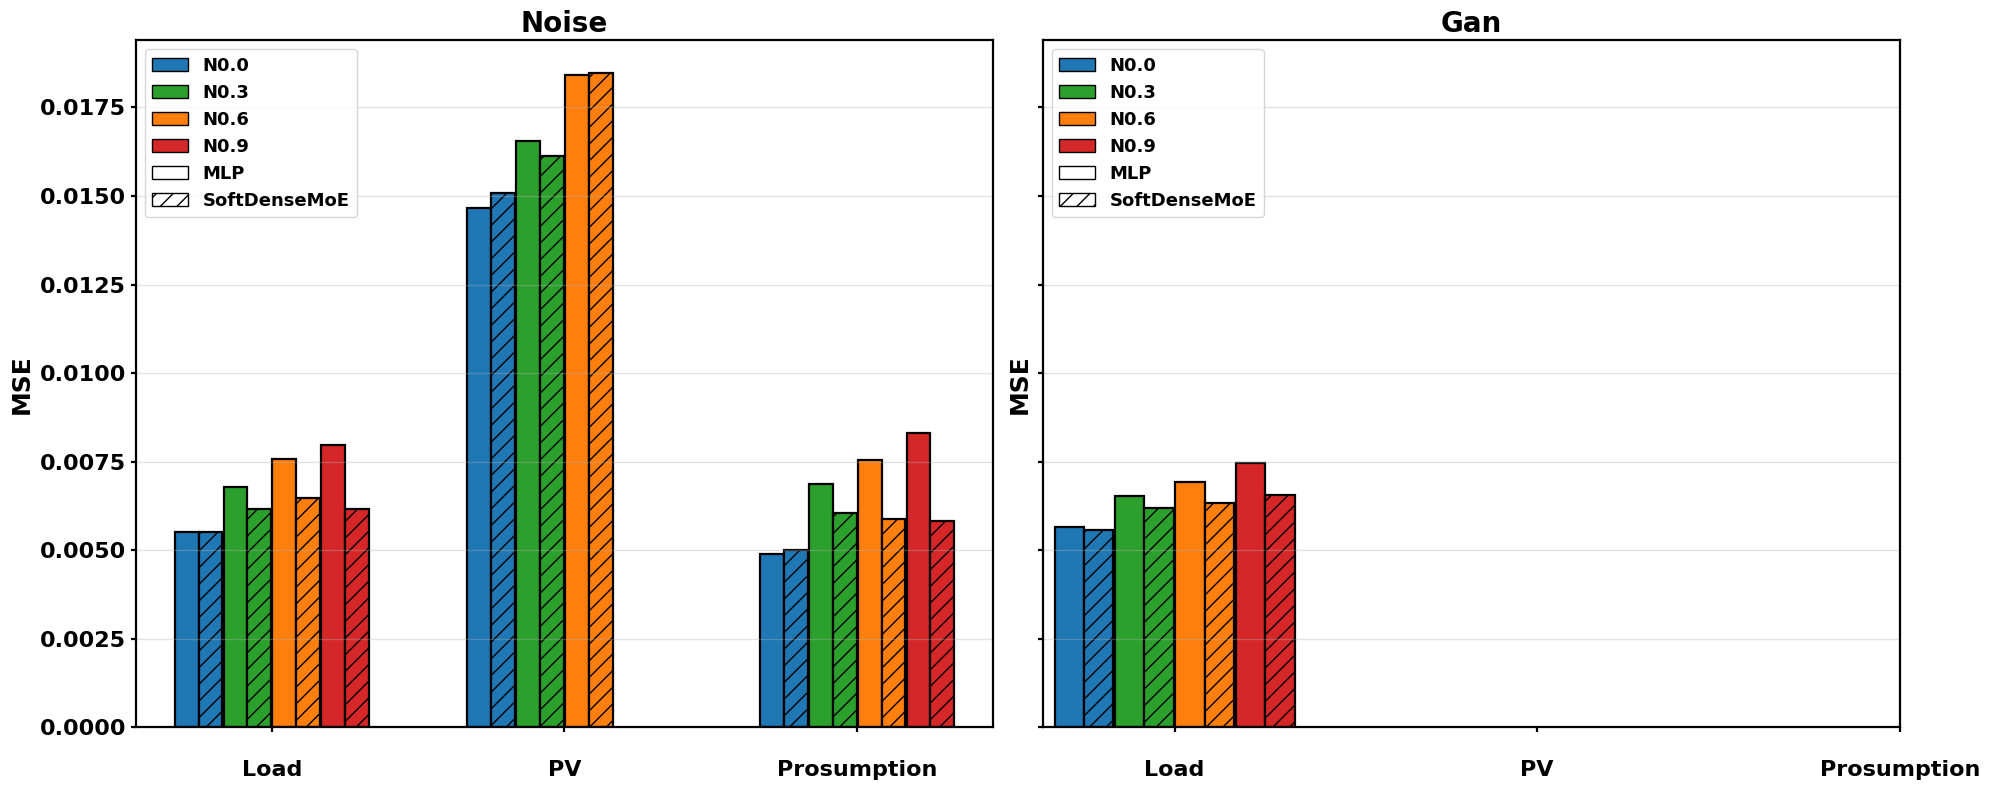

In [59]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

# =========================
# Shared config & helpers
# =========================

ENERGY_MAP_DEFAULT = {"Load": 91, "PV": 92, "Prosumption": 93}
ENERGY_COLORS = {"Load": "#E4D554", "PV": "#294586", "Prosumption": "#903045"}
ENERGY_MARKERS = {"Load": "o", "PV": "s", "Prosumption": "^"}

SCALES = (0.0, 0.3, 0.6, 0.9)
SCALE_COLORS = {0.0: "#1f77b4", 0.3: "#2ca02c", 0.6: "#ff7f0e", 0.9: "#d62728"}  # colorblind-friendly
SCALE_LABEL = lambda s: f"N{s:.1f}"

def _scale_token(x: float) -> str:
    return f"{x:.1f}".replace(".", "p")

def _mid_for(source: str) -> str:
    return "NoiseScale" if source == "noise" else "GanScale"

def _normalize_arch(col: pd.Series) -> pd.Series:
    s = col.astype(str).str.strip().str.lower()
    return np.where(s.str.contains("soft"), "SoftDenseMoE", "MLP")

def _pick_id_col(df: pd.DataFrame) -> str:
    for cand in ["building", "user_key", "user", "cluster_id"]:
        if cand in df.columns:
            return cand
    df["_single_id"] = "ALL"
    return "_single_id"

def _apply_journal_style(ax):
    ax.grid(True, axis="y", linewidth=1.0, alpha=0.35)
    for spine in ax.spines.values():
        spine.set_linewidth(1.6)
    ax.tick_params(axis='both', which='both', labelsize=16, width=1.6)
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontweight('bold')

def _parse_hhmm_to_hour_start(hhmm: str | None) -> int:
    if not hhmm or not isinstance(hhmm, str):
        return 10
    m = re.match(r"^\s*(\d{1,2})(?::(\d{1,2}))?\s*$", hhmm)
    if not m:
        return 10
    return max(0, min(23, int(m.group(1))))

def _poisoned_hours(start_time="10:30", steps=4) -> list[int]:
    h0 = _parse_hhmm_to_hour_start(start_time)
    return [ (h0 + k) % 24 for k in range(int(steps)) ]

def _backdoor_path(results_dir: str, eid: int, energy: str, source: str, scale: float, variant="Attack") -> str:
    # e.g. 91Load_Backdoor_NoiseScale_0p3_Attack_per_hour_results.csv
    return os.path.join(
        results_dir,
        f"{eid}{energy}_Backdoor_{_mid_for(source)}_{_scale_token(scale)}_{variant}_per_hour_results.csv"
    )

def _read_backdoor_df(results_dir: str, energy: str, eid: int, source: str, scale: float, metric: str) -> pd.DataFrame | None:
    p = _backdoor_path(results_dir, eid, energy, source, scale, "Attack")
    if not os.path.exists(p):
        return None
    df = pd.read_csv(p)
    if "hour" not in df.columns or metric not in df.columns:
        return None
    df["hour"] = pd.to_numeric(df["hour"], errors="coerce")
    df["arch_norm"] = _normalize_arch(df["architecture"]) if "architecture" in df.columns else "MLP"
    id_col = _pick_id_col(df)
    df[id_col] = df[id_col].astype(str).str.strip()
    df["_id_col"] = id_col
    return df

def _per_hour_equal_weight(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    """Per-hour mean with equal weight per (ID, architecture)."""
    if df is None or df.empty:
        return pd.DataFrame(columns=["hour", "mean_metric"])
    id_col = df["_id_col"].iloc[0]
    step1 = (df.groupby([id_col, "arch_norm", "hour"], as_index=False)[metric]
               .mean()
               .rename(columns={metric: "m_hour"}))
    step2 = (step1.groupby("hour", as_index=False)["m_hour"]
                   .mean()
                   .rename(columns={"m_hour": "mean_metric"}))
    return step2.sort_values("hour")

def _per_building_poisoned_only(df: pd.DataFrame, metric: str, poisoned_hours: set[int]) -> pd.DataFrame:
    """
    Per-building metric over poisoned hours only, equal-weight across arch and hours:
      1) mean per (ID, arch, hour)
      2) avg across hours per (ID, arch)
      3) avg across arch per ID => one value per building/user
    """
    if df is None or df.empty:
        return pd.DataFrame(columns=["_id_val", "m_id"])
    id_col = df["_id_col"].iloc[0]
    step1 = (df.groupby([id_col, "arch_norm", "hour"], as_index=False)[metric]
               .mean()
               .rename(columns={metric: "m_hour"}))
    sub = step1[step1["hour"].isin(list(poisoned_hours))]
    if sub.empty:
        return pd.DataFrame(columns=["_id_val", "m_id"])
    step2 = (sub.groupby([id_col, "arch_norm"], as_index=False)["m_hour"]
               .mean()
               .rename(columns={"m_hour": "m_id_arch"}))
    step3 = (step2.groupby(id_col, as_index=False)["m_id_arch"]
               .mean()
               .rename(columns={id_col: "_id_val", "m_id_arch": "m_id"}))
    return step3

def _per_arch_poisoned_only(df: pd.DataFrame, metric: str, poisoned_hours: set[int]) -> pd.DataFrame:
    """Return per-architecture (MLP/SoftDenseMoE) mean over poisoned hours only (equal weight per ID)."""
    if df is None or df.empty:
        return pd.DataFrame(columns=["arch_norm", "m_arch"])
    id_col = df["_id_col"].iloc[0]
    step1 = (df.groupby([id_col, "arch_norm", "hour"], as_index=False)[metric]
               .mean()
               .rename(columns={metric: "m_hour"}))
    sub = step1[step1["hour"].isin(list(poisoned_hours))]
    if sub.empty:
        return pd.DataFrame(columns=["arch_norm", "m_arch"])
    step2 = (sub.groupby([id_col, "arch_norm"], as_index=False)["m_hour"]
               .mean()
               .rename(columns={"m_hour": "m_id_arch"}))
    step3 = (step2.groupby("arch_norm", as_index=False)["m_id_arch"]
               .mean()
               .rename(columns={"m_id_arch": "m_arch"}))
    return step3

# ---- Poisoned-hour band helpers (clearer shading + outer boundary lines, with wrap-around) ----
def _segments_from_hours(hours_set: set[int]) -> list[tuple[int,int]]:
    """Return list of inclusive ranges [(start,end)] of consecutive hours modulo 24."""
    if not hours_set:
        return []
    hours = sorted(list(set(int(h)%24 for h in hours_set)))
    # handle wrap-around by checking if last connects to first
    segs = []
    start = prev = hours[0]
    for h in hours[1:]:
        if (prev + 1) % 24 == h:
            prev = h
        else:
            segs.append((start, prev))
            start = prev = h
    segs.append((start, prev))
    # merge first/last if they wrap
    if len(segs) > 1 and (segs[-1][1] + 1) % 24 == segs[0][0]:
        a = segs.pop(0)
        b = segs.pop()
        segs.append((b[0], a[1]))
    return segs

def _draw_poison_band(ax, poisoned_hours: set[int], facecolor="grey"):
    """Shade poisoned-hours block(s) and draw clear boundary lines at the segment edges."""
    segs = _segments_from_hours(poisoned_hours)
    for (a, b) in segs:
        if a <= b:
            ax.axvspan(a, b + 1, color=facecolor, alpha=0.12, zorder=0)
            ax.axvline(a, color=facecolor, linewidth=2.2, linestyle="-", alpha=0.7, zorder=1)
            ax.axvline(b + 1, color=facecolor, linewidth=2.2, linestyle="-", alpha=0.7, zorder=1)
        else:
            # wrap-around: [a,24) U [0,b+1)
            ax.axvspan(a, 24, color=facecolor, alpha=0.12, zorder=0)
            ax.axvspan(0, b + 1, color=facecolor, alpha=0.12, zorder=0)
            ax.axvline(a, color=facecolor, linewidth=2.2, linestyle="-", alpha=0.7, zorder=1)
            ax.axvline(b + 1, color=facecolor, linewidth=2.2, linestyle="-", alpha=0.7, zorder=1)

# ============================================================
# 1) Per-hour lines for each energy (Noise | GAN), highlight BD
# ============================================================
def plot_bd_hourly_lines(
    results_dir="results3",
    energy_map=ENERGY_MAP_DEFAULT,
    metric="mse",
    scales=SCALES,
    backdoor_start_time="10:30",
    backdoor_num_steps=4,
):
    """
    For each energy type, create a figure (20x8) with two subplots: [Noise | GAN].
    Each subplot: lines of metric per hour for all scales (N0.0, N0.3, N0.6, N0.9).
    Poisoned hours are highlighted with shading and bold outer boundary lines.
    """
    metric = metric.lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be one of: 'mse', 'rmse', 'mae'")
    POISONED = set(_poisoned_hours(backdoor_start_time, backdoor_num_steps))

    for energy, eid in energy_map.items():
        fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
        for ax, source in zip(axes, ["noise", "gan"]):
            drawn_any = False
            for s in scales:
                df = _read_backdoor_df(results_dir, energy, eid, source, s, metric)
                perh = _per_hour_equal_weight(df, metric)
                if perh is None or perh.empty:
                    continue
                drawn_any = True
                ax.plot(perh["hour"].values, perh["mean_metric"].values,
                        label=SCALE_LABEL(s),
                        color=SCALE_COLORS[s], linewidth=3.0, marker="o", markersize=7,
                        alpha=0.78)  # a bit transparent as requested
            # highlight poisoned hours (clearer with boundaries)
            ax.set_xlim(-0.5, 23.5)
            ax.set_xticks(range(0, 24, 2))
            _draw_poison_band(ax, POISONED, facecolor="#444444")

            ax.set_xlabel("Hour of day", fontsize=18, fontweight="bold")
            ax.set_ylabel(metric.upper(), fontsize=18, fontweight="bold")
            ax.set_title(f"{energy} — {source.capitalize()}", fontsize=20, fontweight="bold")
            _apply_journal_style(ax)
            ax.tick_params(axis='x', which='major', pad=14)
            if drawn_any:
                leg = ax.legend(loc="best", fontsize=14, frameon=True)
                if leg:
                    for txt in leg.get_texts(): txt.set_fontweight("bold")
        plt.tight_layout()
        plt.show()

# ======================================================================
# 2) Six heatmaps (3 energies × 2 sources): Δ% per hour (N0.9 vs N0.0)
# ======================================================================
def plot_bd_hourly_delta_heatmaps(
    results_dir="results3",
    energy_map={"Load": 91, "PV": 92, "Prosumption": 93},
    metric="mse",
    robust_percentile=95,      # robust color scaling percentile (symmetric around 0)
    cmap_name="coolwarm",      # diverging
    right_margin=0.88,         # leave space for colorbar (0–1 figure fraction)
    cbar_box=(0.90, 0.15, 0.02, 0.70),  # [left, bottom, width, height] in figure fraction
):
    """
    One figure with 2 rows x 3 cols subplots (top row = Noise, bottom row = GAN).
    Each heatmap shows Δ% per hour = (N0.9 - N0.0)/N0.0 * 100 aggregated per hour
    (equal weight per ID, arch, via _per_hour_equal_weight and _read_backdoor_df from earlier code).

    Colorbar is placed on the RIGHT with reserved space. Color limits are set using a robust
    symmetric scaling based on the given percentile of |Δ%| across all panels.
    """
    metric = str(metric).lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be one of: 'mse', 'rmse', 'mae'")

    def per_hour_delta(eid, energy, source):
        d0 = _per_hour_equal_weight(_read_backdoor_df(results_dir, energy, eid, source, 0.0, metric), metric)
        d9 = _per_hour_equal_weight(_read_backdoor_df(results_dir, energy, eid, source, 0.9, metric), metric)
        if d0.empty or d9.empty:
            return np.full(24, np.nan)
        m = pd.merge(d0, d9, on="hour", how="inner", suffixes=("_0", "_9"))
        if m.empty:
            return np.full(24, np.nan)
        full = pd.DataFrame({"hour": np.arange(24)}).merge(m, on="hour", how="left")
        base = full["mean_metric_0"].to_numpy(dtype=float)
        val9 = full["mean_metric_9"].to_numpy(dtype=float)
        with np.errstate(divide="ignore", invalid="ignore"):
            delta = (val9 - base) / base * 100.0
        return delta

    # Collect all deltas to compute robust symmetric vmin/vmax
    energies = list(energy_map.keys())
    all_vals = []
    panels = {}  # (row,col) -> array(1x24)
    for col, energy in enumerate(energies):
        eid = energy_map[energy]
        arrN = per_hour_delta(eid, energy, "noise")
        arrG = per_hour_delta(eid, energy, "gan")
        panels[(0, col)] = arrN.reshape(1, -1)
        panels[(1, col)] = arrG.reshape(1, -1)
        all_vals.extend(arrN[np.isfinite(arrN)])
        all_vals.extend(arrG[np.isfinite(arrG)])

    # Robust symmetric limits
    if len(all_vals) == 0:
        vmax_abs = 50.0
    else:
        q = np.nanpercentile(np.abs(all_vals), robust_percentile)
        vmax_abs = q if np.isfinite(q) and q > 0 else 50.0
    vmin, vmax = -vmax_abs, vmax_abs

    # Shared colormap & norm (center at 0)
    cmap = plt.get_cmap(cmap_name)
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

    # Make the grid and reserve space on the right for the colorbar
    fig, axes = plt.subplots(2, 3, figsize=(20, 8), sharex=True, sharey=True)
    fig.subplots_adjust(right=right_margin, wspace=0.25, hspace=0.30)

    ims = []
    for (r, c), arr in panels.items():
        im = axes[r, c].imshow(arr, aspect="auto", cmap=cmap, norm=norm)
        ims.append(im)
        title_src = "Noise" if r == 0 else "GAN"
        axes[r, c].set_title(f"{energies[c]} — {title_src}", fontsize=16, fontweight="bold")
        axes[r, c].set_yticks([])  # single-row heat per energy
        axes[r, c].set_xticks(range(0, 24, 2))
        _apply_journal_style(axes[r, c])

    # Dedicated colorbar axis on the right
    cax = fig.add_axes(cbar_box)  # [left, bottom, width, height]
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax)
    cbar.ax.tick_params(labelsize=14, width=1.2)
    cbar.set_label(f"Δ% {metric.upper()} (N0.9 vs N0.0) — robust scale ±{vmax_abs:.1f}%", fontsize=16, fontweight="bold")

    plt.show()

# =======================================================================================
# 3) Violins: per-building metric across scales, grouped by energy (Noise | GAN panels)
#     + informative print statements
# =======================================================================================
def plot_bd_building_violins_by_scale(
    results_dir="results3",
    energy_map=ENERGY_MAP_DEFAULT,
    metric="mse",
    scales=SCALES,
    backdoor_start_time="10:30",
    backdoor_num_steps=4,
):
    """
    Two subplots [Noise | GAN]. X-axis grouped by energy (3 groups).
    Within each energy group, up to 4 violins (N0.0, N0.3, N0.6, N0.9) — per-building distribution
    over POISONED HOURS only (equal weight per arch & hour).
    Includes print statements summarizing what's shown.
    """
    metric = metric.lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be one of: 'mse', 'rmse', 'mae'")
    POISONED = set(_poisoned_hours(backdoor_start_time, backdoor_num_steps))

    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
    energies = list(energy_map.keys())
    n_groups = len(energies)
    group_centers = np.arange(n_groups)  # 0,1,2
    group_width = 0.7
    offsets = np.linspace(-group_width/2, group_width/2, num=len(scales))

    for ax, source in zip(axes, ["noise", "gan"]):
        print(f"\n[Backdoor Violin] Source={source.capitalize()}, Metric={metric.upper()}")
        all_positions, all_arrays, all_colors = [], [], []
        for gi, energy in enumerate(energies):
            eid = energy_map[energy]
            counts = {}
            pooled_vals = []
            for oi, s in enumerate(scales):
                df = _read_backdoor_df(results_dir, energy, eid, source, s, metric)
                per_id = _per_building_poisoned_only(df, metric, POISONED)
                arr = per_id["m_id"].to_numpy(dtype=float) if not per_id.empty else np.array([])
                counts[SCALE_LABEL(s)] = int(arr.size)
                if arr.size > 0:
                    pooled_vals.append(arr)
                    pos = gi + 1 + offsets[oi]
                    all_positions.append(pos)
                    all_arrays.append(arr)
                    all_colors.append(SCALE_COLORS[s])
            # Print summary for this energy
            if len(pooled_vals) > 0:
                med = float(np.nanmedian(np.concatenate(pooled_vals)))
                print(f"  {energy}: counts per scale {counts}; pooled median={med:.4f}")
            else:
                print(f"  {energy}: no data for any scale")

        # Draw violins
        if all_arrays:
            parts = ax.violinplot(all_arrays, positions=all_positions, showmeans=True,
                                  showextrema=False, widths=0.14)
            for body, c in zip(parts['bodies'], all_colors):
                body.set_facecolor(c); body.set_edgecolor("black")
                body.set_alpha(0.70); body.set_linewidth(1.2)
            parts['cmeans'].set_edgecolor("black"); parts['cmeans'].set_linewidth(1.6)

        # X ticks per energy group
        ax.set_xticks(group_centers + 1)
        ax.set_xticklabels(energies, fontsize=16, fontweight="bold")
        ax.tick_params(axis='x', which='major', pad=18)

        ax.set_ylabel(metric.upper(), fontsize=18, fontweight="bold")
        ax.set_title(f"{source.capitalize()}", fontsize=20, fontweight="bold")
        _apply_journal_style(ax)

        # Legend for scales
        handles = [Patch(facecolor=SCALE_COLORS[s], edgecolor="black", label=SCALE_LABEL(s)) for s in scales]
        leg = ax.legend(handles=handles, loc="best", fontsize=13, frameon=True, title="Scale")
        if leg and leg.get_title():
            leg.get_title().set_fontsize(14); leg.get_title().set_fontweight("bold")

    plt.tight_layout()
    plt.show()

# ==========================================================================================
# 4) Bars: model performance per noise scale grouped by energy (Noise | GAN panels)
#     + increased spacing between groups
# ==========================================================================================
def plot_bd_model_bars_by_scale(
    results_dir="results3",
    energy_map=ENERGY_MAP_DEFAULT,
    metric="mse",
    scales=SCALES,
    backdoor_start_time="10:30",
    backdoor_num_steps=4,
):
    """
    Two subplots [Noise | GAN]. For each energy group, show 4 scale sub-clusters (N0.0,N0.3,N0.6,N0.9),
    each sub-cluster has 2 bars (MLP, SoftDenseMoE). Values are **poisoned hours only** (equal-weight).
    Colors = scales; hatches = model. Increased spacing between energy groups.
    """
    metric = metric.lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be one of: 'mse', 'rmse', 'mae'")
    POISONED = set(_poisoned_hours(backdoor_start_time, backdoor_num_steps))
    energies = list(energy_map.keys())
    archs = ["MLP", "SoftDenseMoE"]

    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

    # Increased spacing between groups:
    group_spacing = 1.6  # > 1.0 spreads groups further apart
    group_centers = np.arange(len(energies)) * group_spacing
    group_width = 0.80
    scale_offsets = np.linspace(-group_width/2, group_width/2, num=len(scales))
    bar_width = 0.13

    for ax, source in zip(axes, ["noise", "gan"]):
        for gi, energy in enumerate(energies):
            eid = energy_map[energy]
            for si, s in enumerate(scales):
                df = _read_backdoor_df(results_dir, energy, eid, source, s, metric)
                per_arch = _per_arch_poisoned_only(df, metric, POISONED)
                y_mlp  = float(per_arch.loc[per_arch["arch_norm"]=="MLP",        "m_arch"].mean()) if not per_arch.empty else np.nan
                y_soft = float(per_arch.loc[per_arch["arch_norm"]=="SoftDenseMoE","m_arch"].mean()) if not per_arch.empty else np.nan
                x_center = group_centers[gi] + scale_offsets[si]
                ax.bar(x_center - bar_width/2, y_mlp,  width=bar_width, color=SCALE_COLORS[s],
                       edgecolor="black", linewidth=1.6, hatch="",  label=None)
                ax.bar(x_center + bar_width/2, y_soft, width=bar_width, color=SCALE_COLORS[s],
                       edgecolor="black", linewidth=1.6, hatch="//", label=None)

        # X ticks & labels (at group centers)
        ax.set_xticks(group_centers)
        ax.set_xticklabels(energies, fontsize=16, fontweight="bold")
        ax.tick_params(axis='x', which='major', pad=20)

        ax.set_ylabel(metric.upper(), fontsize=18, fontweight="bold")
        ax.set_title(f"{source.capitalize()}", fontsize=20, fontweight="bold")
        _apply_journal_style(ax)

        # Single legend: scales + models
        scale_handles = [Patch(facecolor=SCALE_COLORS[s], edgecolor="black", label=SCALE_LABEL(s)) for s in scales]
        model_handles = [
            Patch(facecolor="white", edgecolor="black", hatch="",  label="MLP"),
            Patch(facecolor="white", edgecolor="black", hatch="//", label="SoftDenseMoE"),
        ]
        handles = scale_handles + model_handles
        leg = ax.legend(handles=handles, loc="upper left", fontsize=13, frameon=True)
        if leg:
            for txt in leg.get_texts(): txt.set_fontweight("bold")

    plt.tight_layout()
    plt.show()

# 1) Per-hour lines (3 figures, one per energy), highlight poisoned hours
plot_bd_hourly_lines(metric="mse")          # or "rmse"/"mae"

# 2) Six heatmaps (Δ% N0.9 vs N0.0 per hour), one figure
plot_bd_hourly_delta_heatmaps(metric="mse")

# 3) Violin distributions per building (poisoned hours only), by scale, grouped by energy
plot_bd_building_violins_by_scale(metric="mse")

# 4) Model performance bars per scale (poisoned hours only), grouped by energy
plot_bd_model_bars_by_scale(metric="mse")


### Security Measures

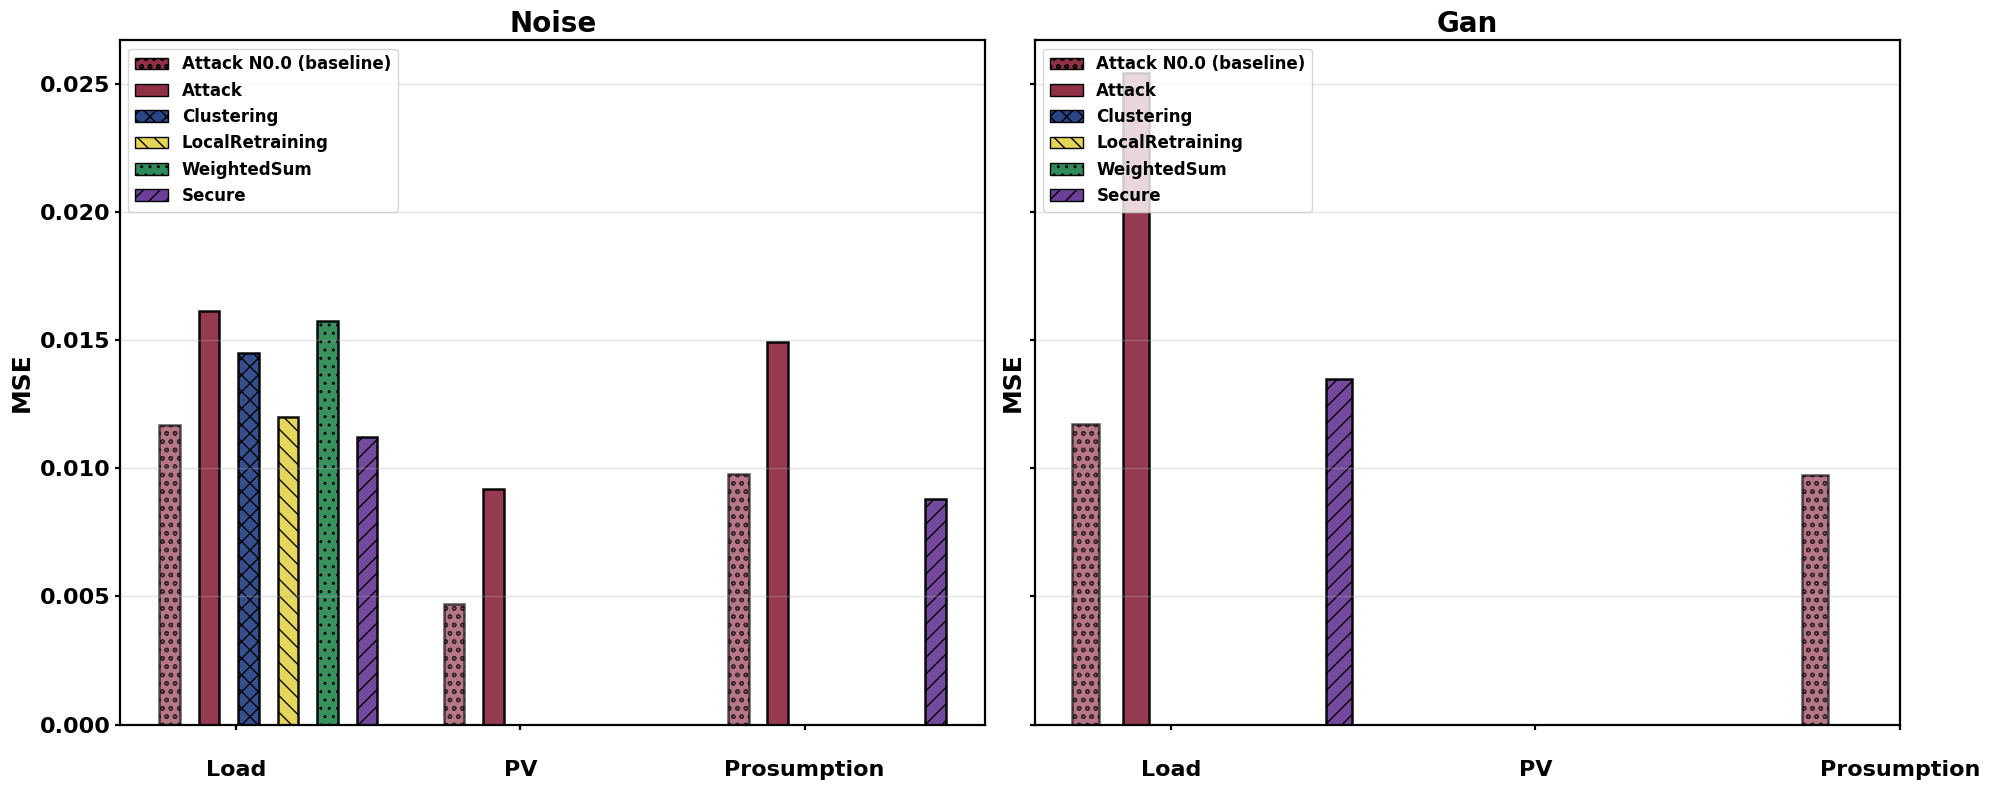

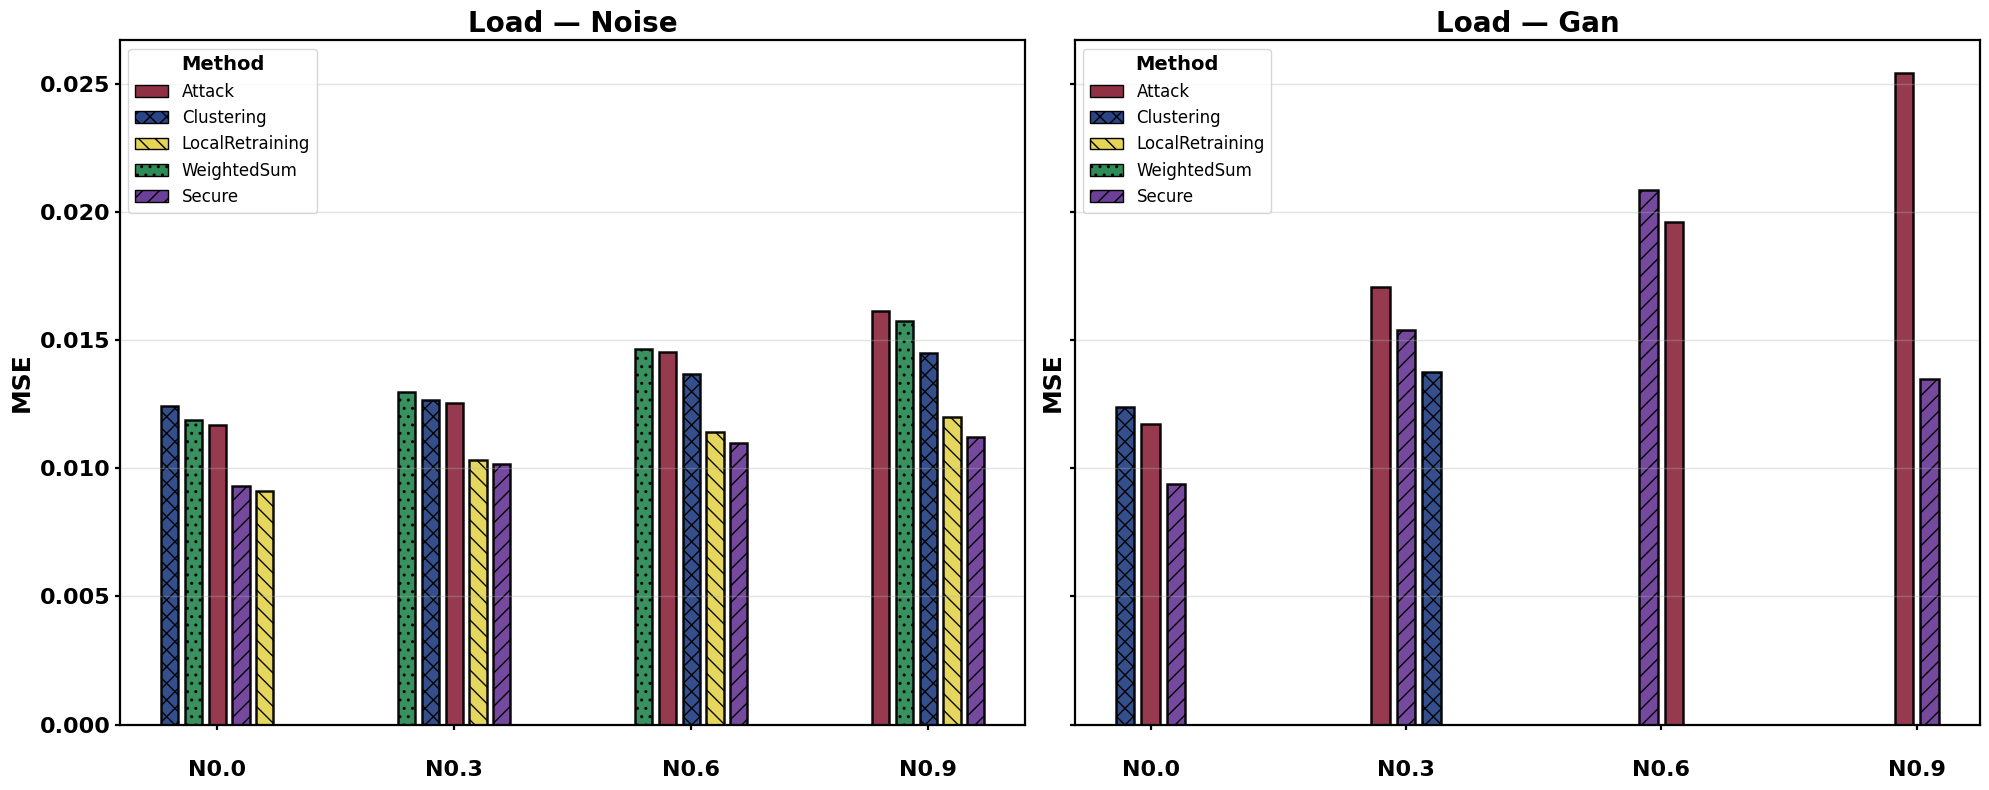

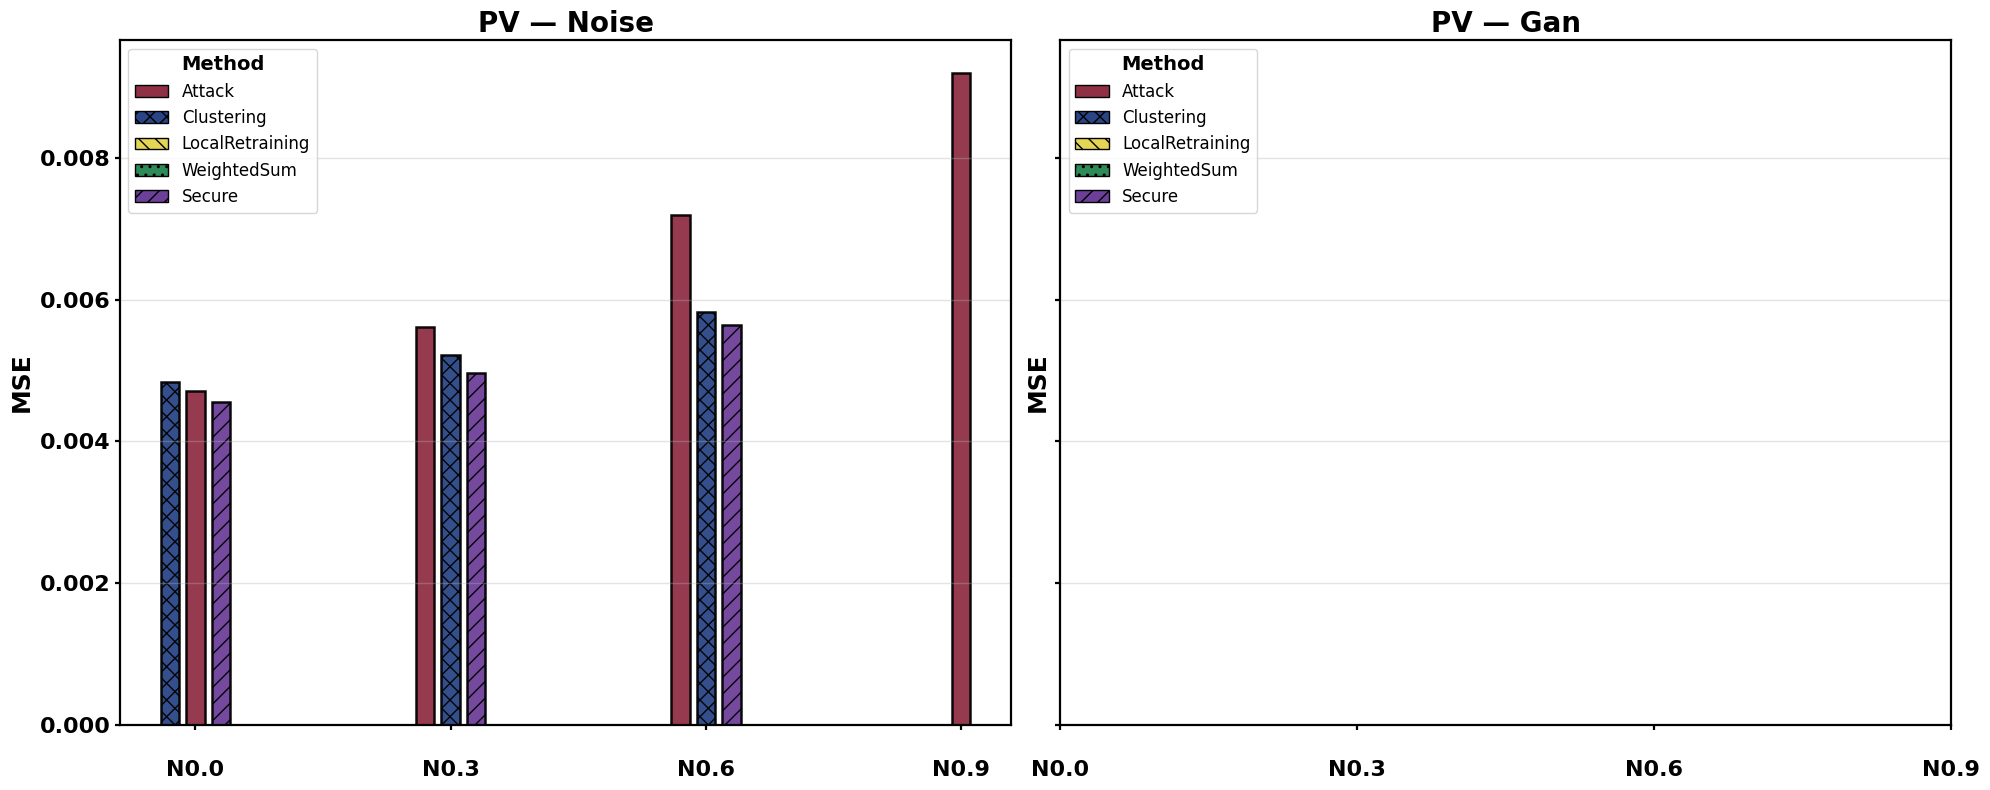

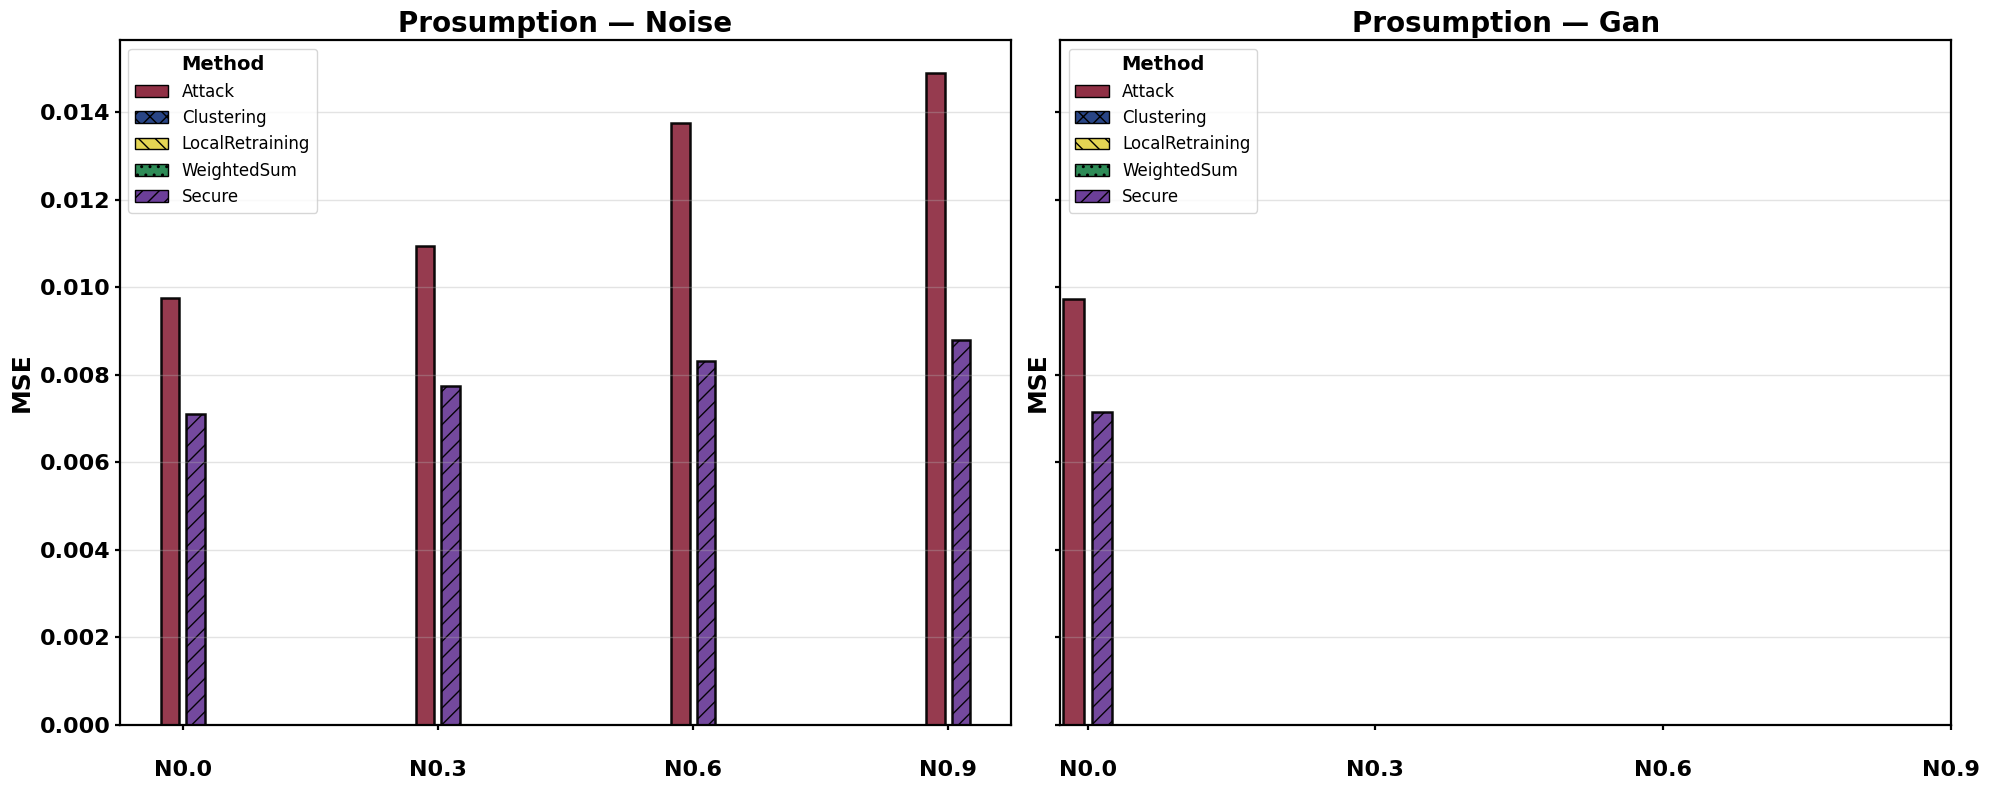

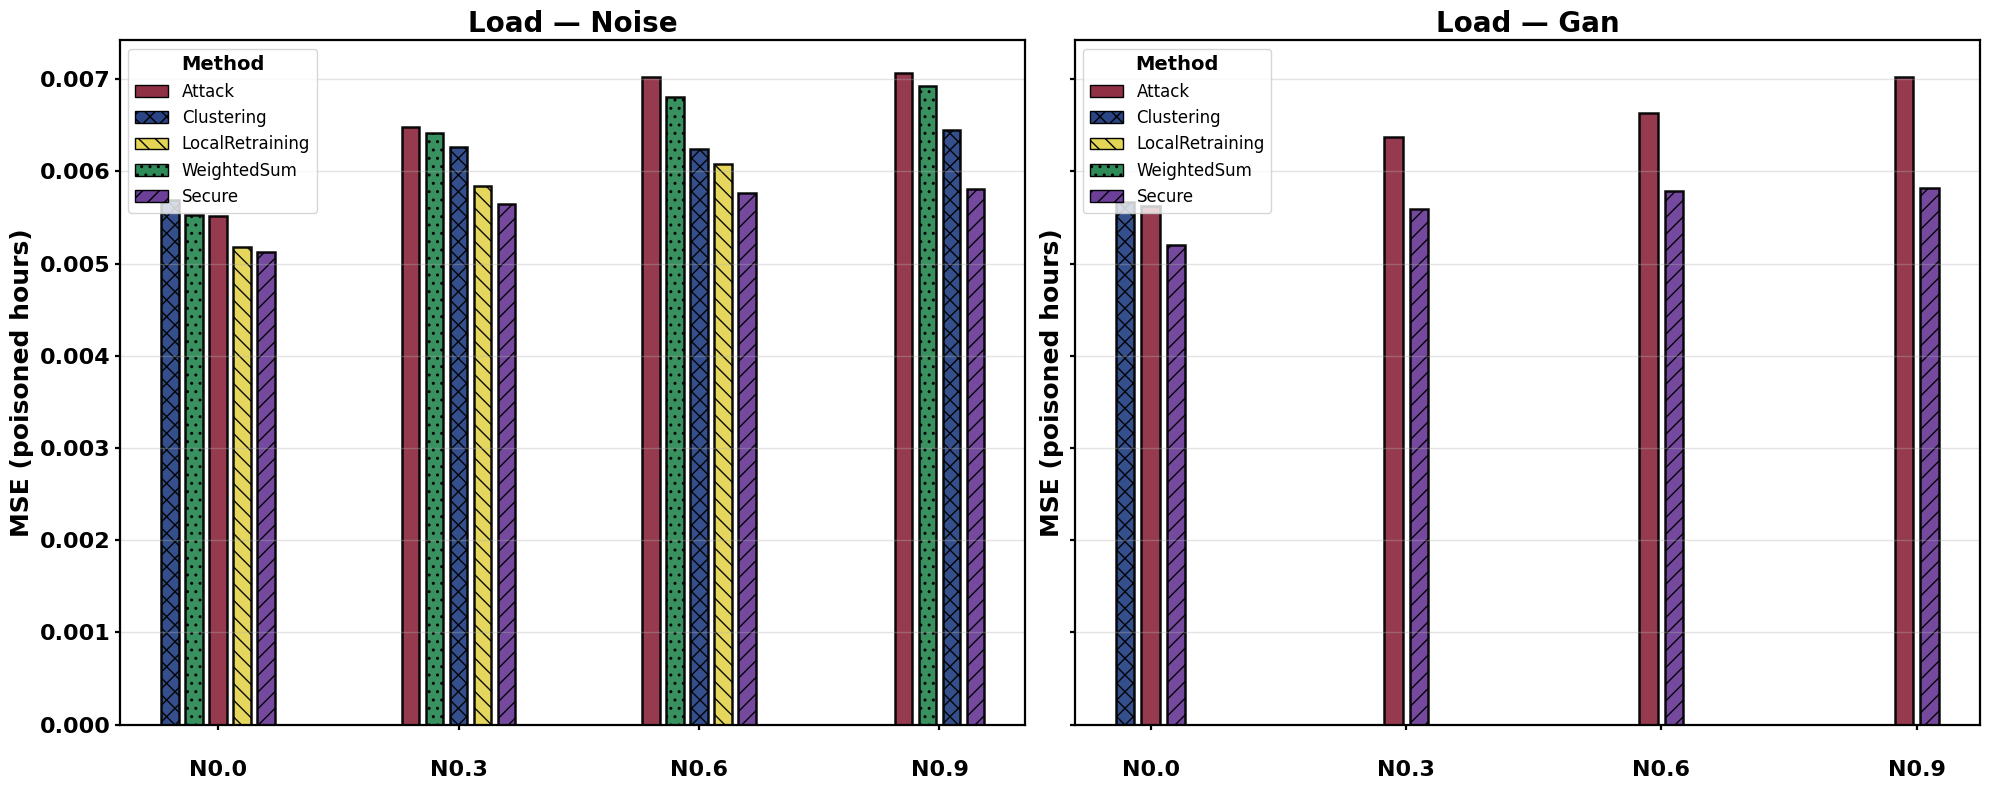

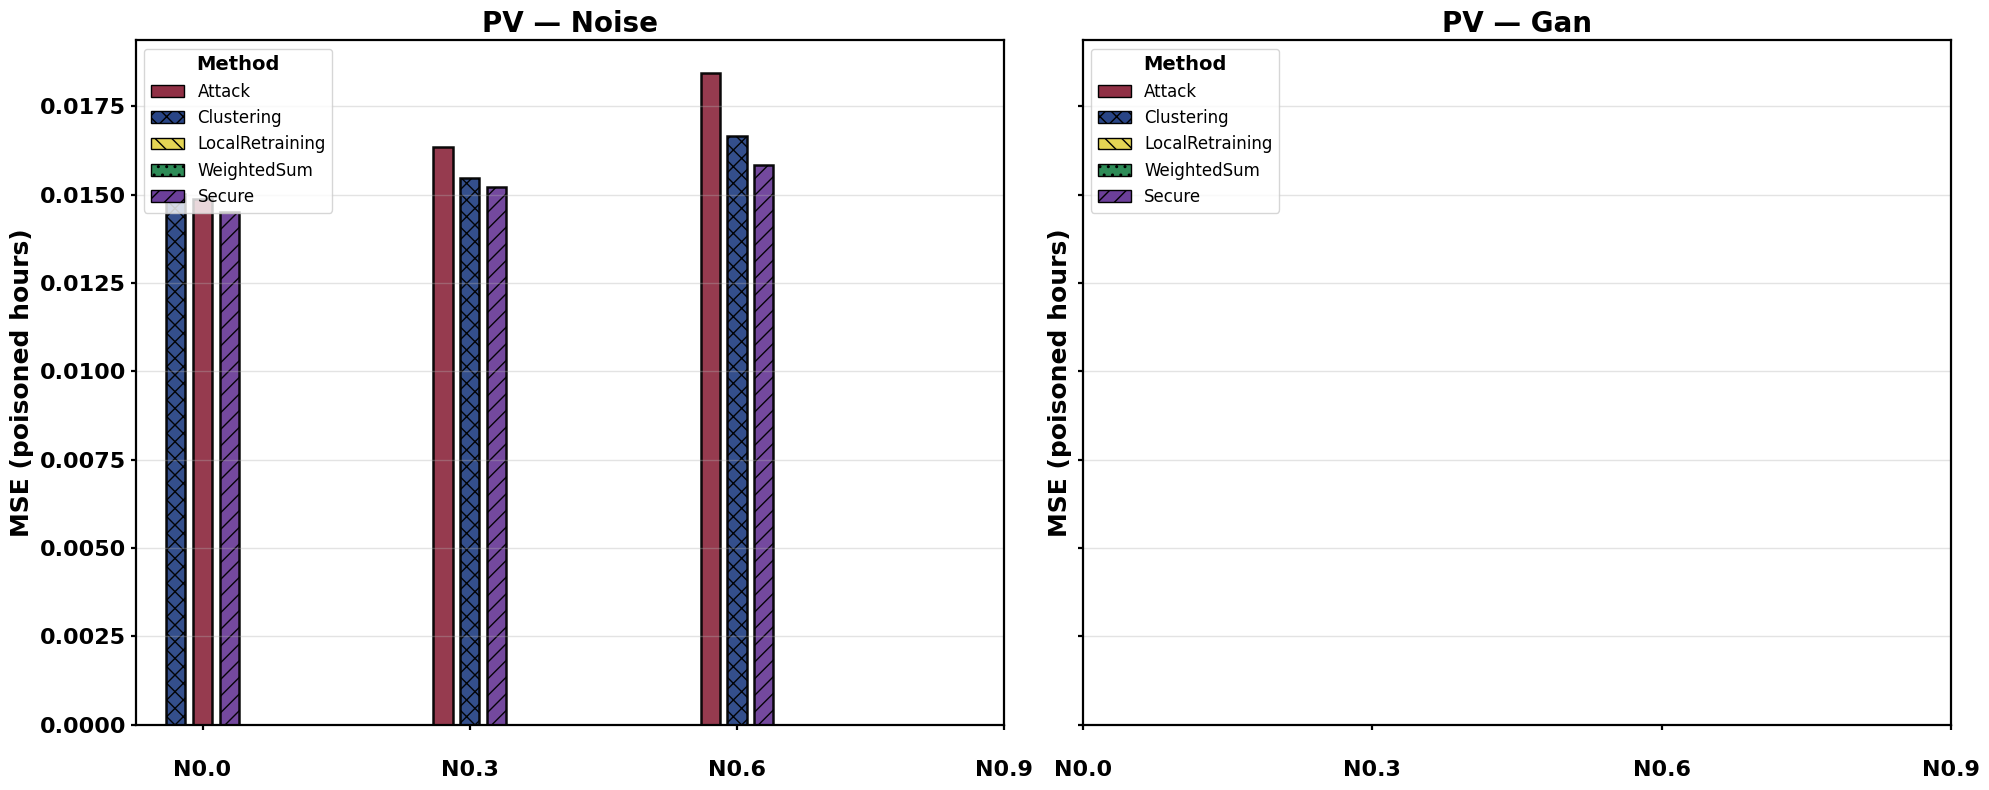

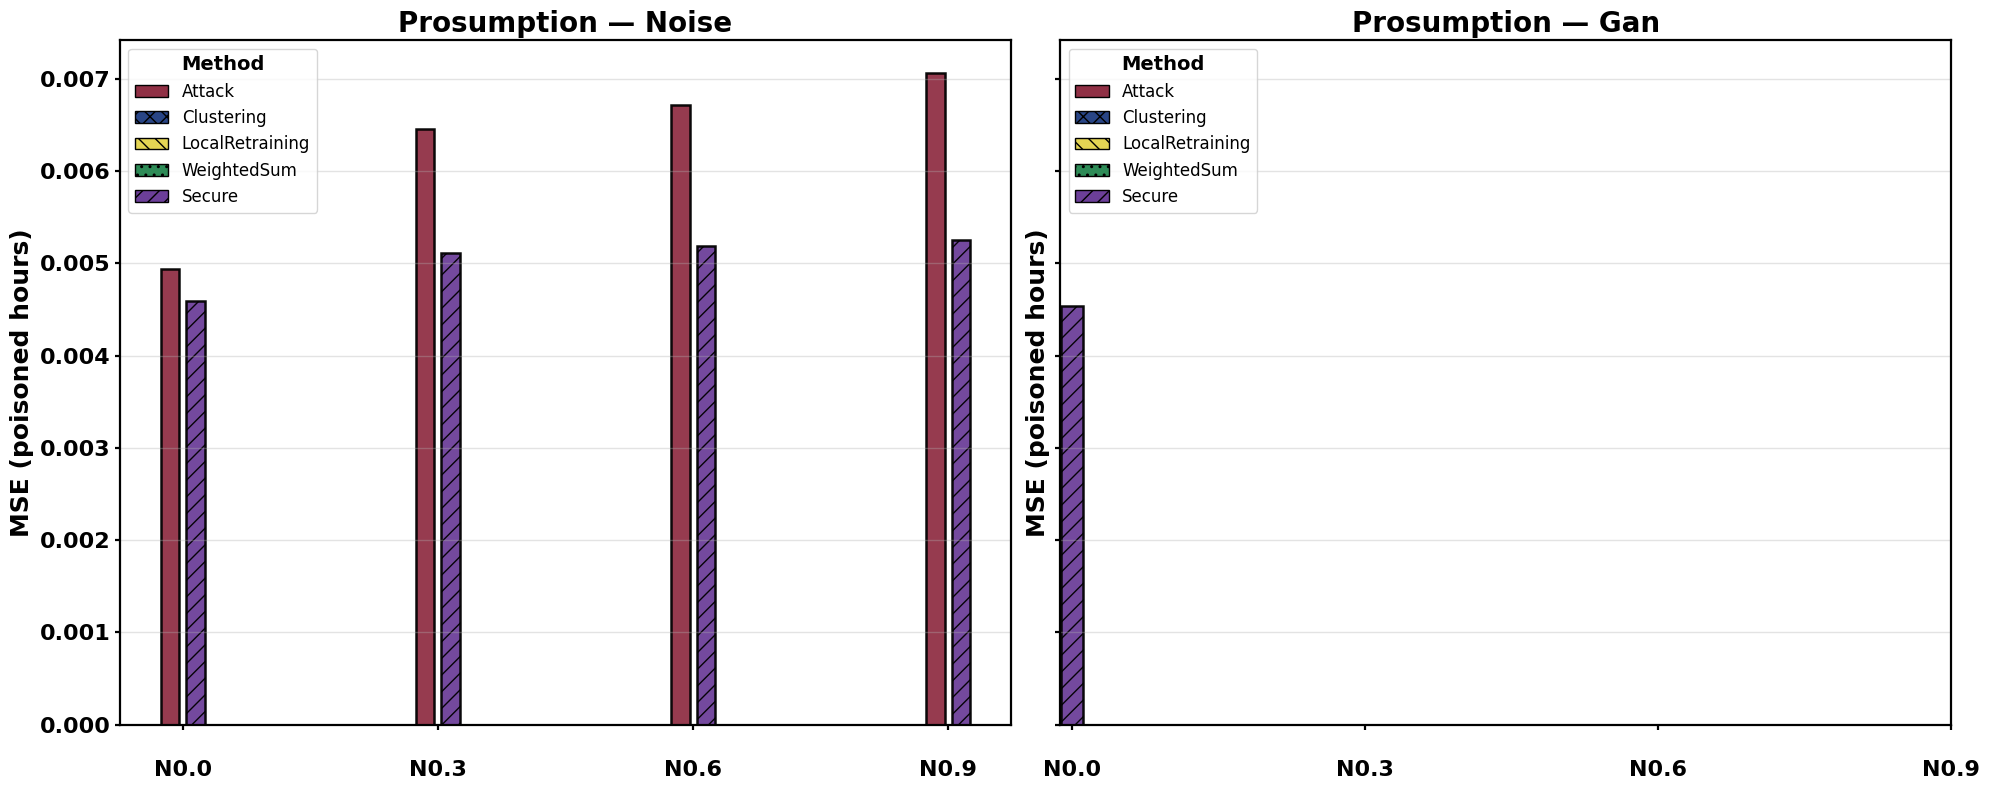

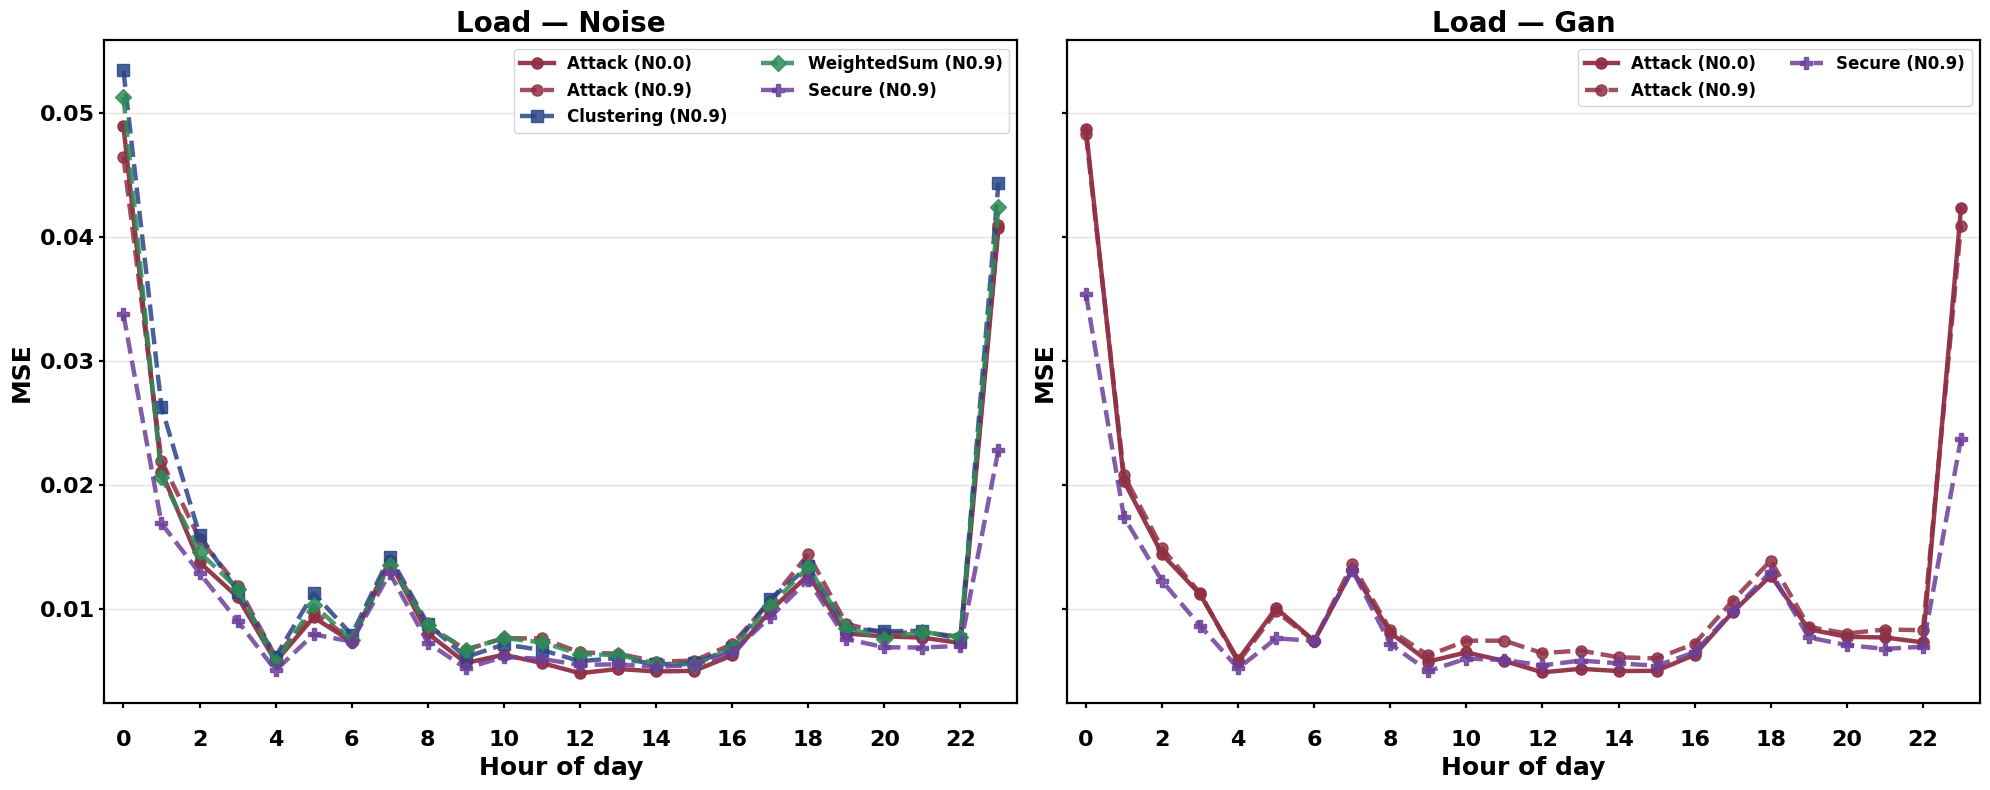

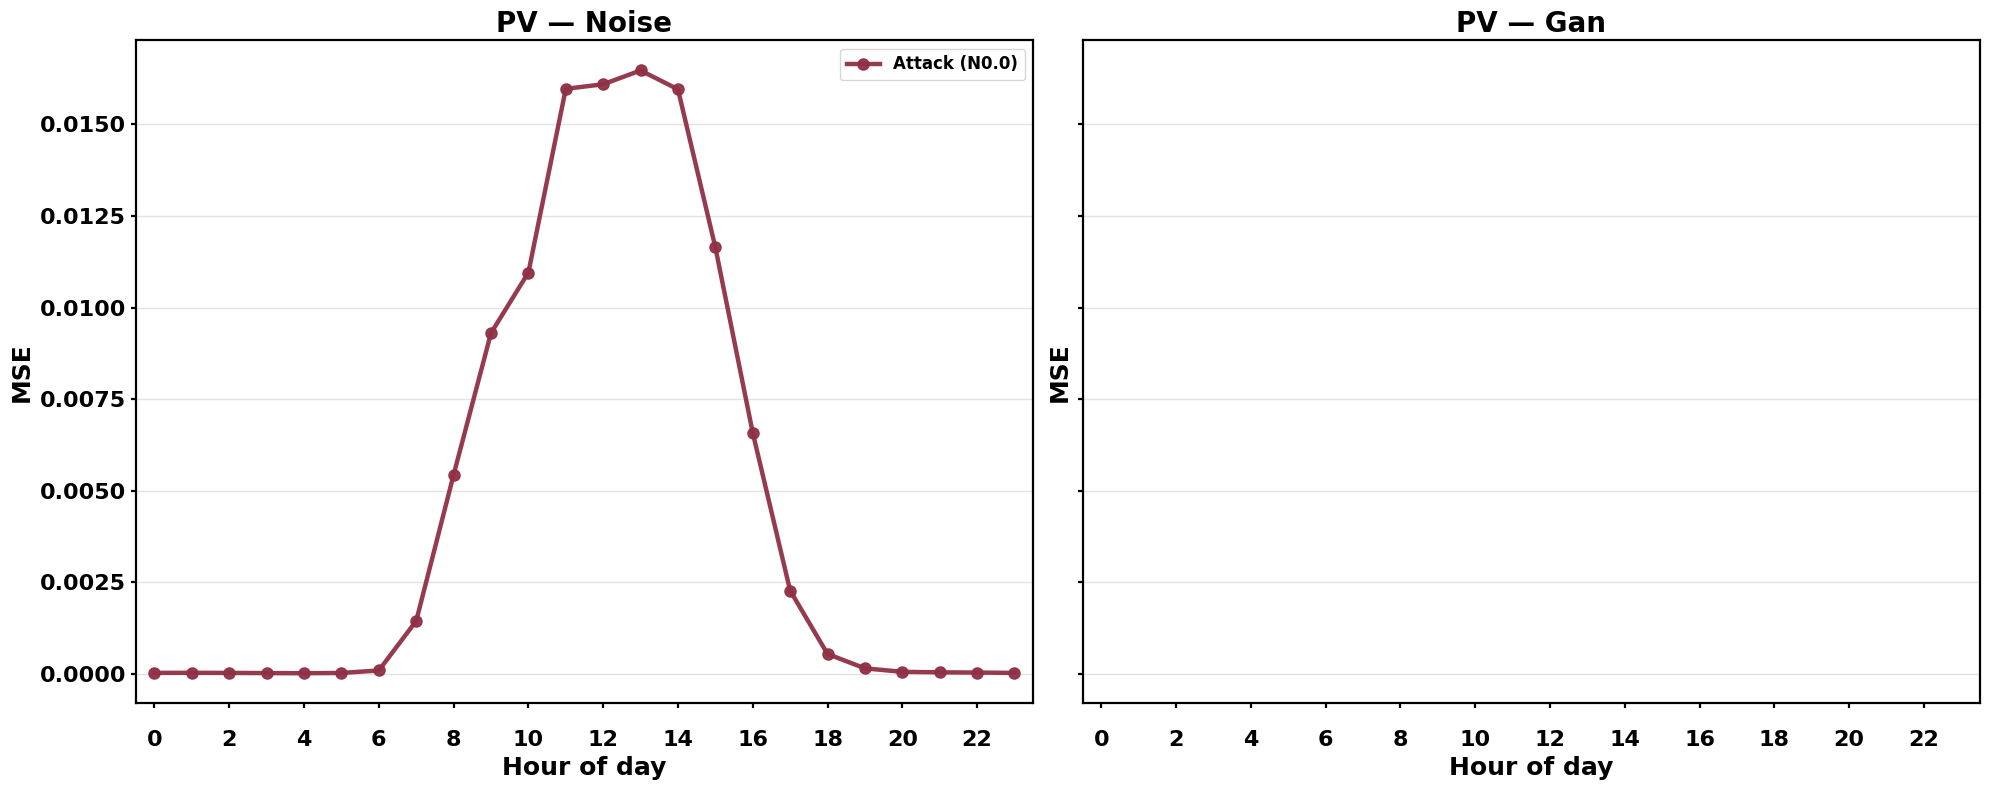

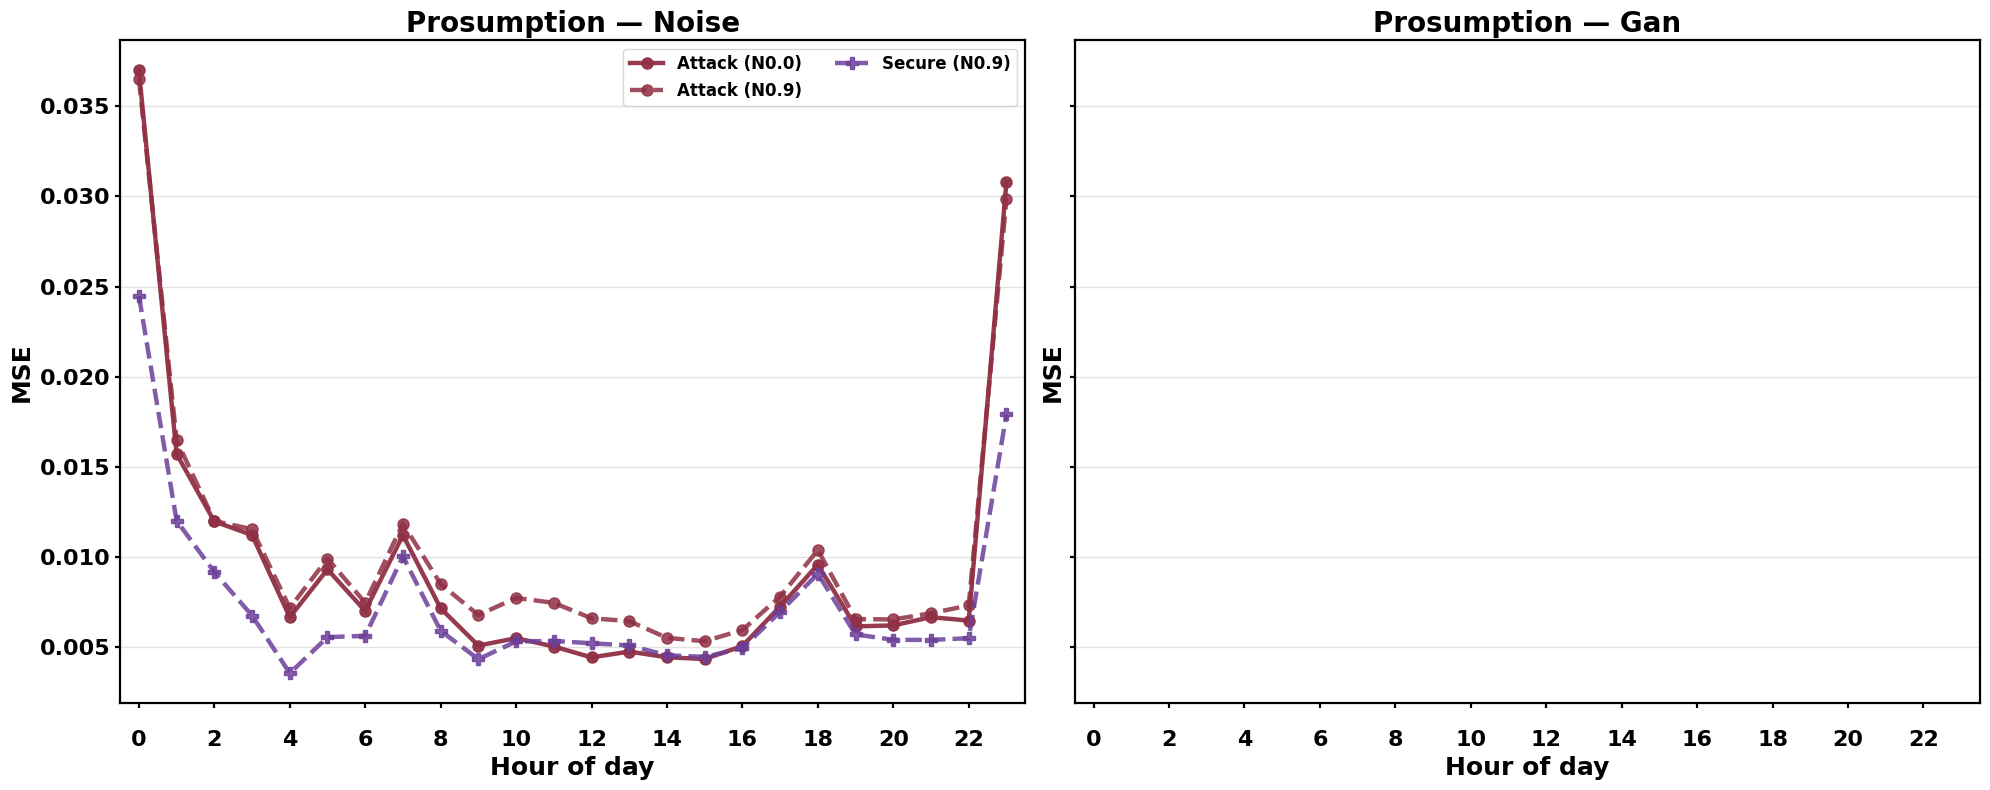

In [62]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# =========================
# Shared config & helpers
# =========================

ENERGY_MAP_DEFAULT = {"Load": 91, "PV": 92, "Prosumption": 93}

# Your signature colors (used elsewhere if needed)
ENERGY_COLORS = {"Load": "#E4D554", "PV": "#294586", "Prosumption": "#903045"}

# --- Method color palette (distinct within each plot) ---
METHODS = ["Attack", "Clustering", "LocalRetraining", "WeightedSum", "Secure"]
METHOD_COLORS = {
    "Attack":          "#903045",  # your maroon
    "Clustering":      "#294586",  # your navy
    "LocalRetraining": "#E4D554",  # your gold
    "WeightedSum":     "#2E8B57",  # matching sea green
    "Secure":          "#6C3F99",  # matching plum
}
METHOD_HATCH = {
    "Attack": "",
    "Clustering": "xx",
    "LocalRetraining": "\\\\",
    "WeightedSum": "..",
    "Secure": "//",
}

# Scales
SCALES = (0.0, 0.3, 0.6, 0.9)
SCALE_LABEL = lambda s: f"N{s:.1f}"

def _scale_token(x: float) -> str:
    return f"{x:.1f}".replace(".", "p")

def _mid_for(source: str) -> str:
    return "NoiseScale" if source == "noise" else "GanScale"

def _normalize_arch(col: pd.Series) -> pd.Series:
    s = col.astype(str).str.strip().str.lower()
    return np.where(s.str.contains("soft"), "SoftDenseMoE", "MLP")

def _apply_journal_style(ax):
    ax.grid(True, axis="y", linewidth=1.0, alpha=0.35)
    for spine in ax.spines.values():
        spine.set_linewidth(1.6)
    ax.tick_params(axis='both', which='both', labelsize=16, width=1.6)
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontweight('bold')

def _pick_id_col(df: pd.DataFrame) -> str:
    for cand in ["building", "user_key", "user", "cluster_id"]:
        if cand in df.columns:
            return cand
    df["_single_id"] = "ALL"
    return "_single_id"

# ---------- Poisoning file IO + aggregation ----------
def _poison_path_variant(results_dir: str, eid: int, energy: str, source: str, scale: float, variant: str) -> str:
    return os.path.join(
        results_dir,
        f"{eid}{energy}_Poison_{_mid_for(source)}_{_scale_token(scale)}_{variant}_all_results.csv"
    )

def _read_poison_df_variant(results_dir: str, energy: str, eid: int, source: str, scale: float, variant: str, metric: str):
    p = _poison_path_variant(results_dir, eid, energy, source, scale, variant)
    if not os.path.exists(p):
        return None
    df = pd.read_csv(p)
    if metric not in df.columns:
        return None
    df["arch_norm"] = _normalize_arch(df["architecture"]) if "architecture" in df.columns else "MLP"
    df["building"] = df["building"].astype(str).str.strip()
    return df

def _per_building_arch_mean(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    if df is None or df.empty:
        return pd.DataFrame(columns=["building", "arch_norm", "m"])
    g = (df.groupby(["building", "arch_norm"], as_index=False)[metric]
           .mean()
           .rename(columns={metric: "m"}))
    return g

def _overall_mean_equal_building_arch(df: pd.DataFrame, metric: str) -> float:
    """Equal weight per (building, arch) across the whole dataframe."""
    if df is None or df.empty:
        return np.nan
    g = _per_building_arch_mean(df, metric)
    return float(g["m"].mean()) if not g.empty else np.nan

# ---------- Backdoor file IO + aggregation ----------
def _backdoor_path_variant(results_dir: str, eid: int, energy: str, source: str, scale: float, variant: str) -> str:
    return os.path.join(
        results_dir,
        f"{eid}{energy}_Backdoor_{_mid_for(source)}_{_scale_token(scale)}_{variant}_per_hour_results.csv"
    )

def _read_backdoor_df_variant(results_dir: str, energy: str, eid: int, source: str, scale: float, variant: str, metric: str):
    p = _backdoor_path_variant(results_dir, eid, energy, source, scale, variant)
    if not os.path.exists(p):
        return None
    df = pd.read_csv(p)
    if "hour" not in df.columns or metric not in df.columns:
        return None
    df["hour"] = pd.to_numeric(df["hour"], errors="coerce")
    df["arch_norm"] = _normalize_arch(df["architecture"]) if "architecture" in df.columns else "MLP"
    id_col = _pick_id_col(df)
    df[id_col] = df[id_col].astype(str).str.strip()
    df["_id_col"] = id_col
    return df

def _per_hour_equal_weight(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    """Per-hour mean with equal weight per (ID, architecture)."""
    if df is None or df.empty:
        return pd.DataFrame(columns=["hour", "mean_metric"])
    id_col = df["_id_col"].iloc[0]
    step1 = (df.groupby([id_col, "arch_norm", "hour"], as_index=False)[metric]
               .mean()
               .rename(columns={metric: "m_hour"}))
    step2 = (step1.groupby("hour", as_index=False)["m_hour"]
                   .mean()
                   .rename(columns={"m_hour": "mean_metric"}))
    return step2.sort_values("hour")

def _poisoned_hours(start_time="10:30", steps=4) -> set[int]:
    # 10:30 -> 10
    m = re.match(r"^\s*(\d{1,2})", start_time)
    h0 = int(m.group(1)) if m else 10
    return { (h0 + k) % 24 for k in range(int(steps)) }

def _per_building_poisoned_only(df: pd.DataFrame, metric: str, poisoned_hours: set[int]) -> pd.DataFrame:
    """One value per building/user over poisoned hours only (equal weight per arch & hour)."""
    if df is None or df.empty:
        return pd.DataFrame(columns=["_id_val", "m_id"])
    id_col = df["_id_col"].iloc[0]
    step1 = (df.groupby([id_col, "arch_norm", "hour"], as_index=False)[metric]
               .mean()
               .rename(columns={metric: "m_hour"}))
    sub = step1[step1["hour"].isin(list(poisoned_hours))]
    if sub.empty:
        return pd.DataFrame(columns=["_id_val", "m_id"])
    step2 = (sub.groupby([id_col, "arch_norm"], as_index=False)["m_hour"]
               .mean()
               .rename(columns={"m_hour": "m_id_arch"}))
    step3 = (step2.groupby(id_col, as_index=False)["m_id_arch"]
               .mean()
               .rename(columns={id_col: "_id_val", "m_id_arch": "m_id"}))
    return step3

def _overall_mean_poisoned_only(df: pd.DataFrame, metric: str, poisoned_hours: set[int]) -> float:
    per_id = _per_building_poisoned_only(df, metric, poisoned_hours)
    return float(per_id["m_id"].mean()) if not per_id.empty else np.nan

# ============================================================
# 0) Poisoning — Overview bars per energy:
#     N0.0 baseline (Attack) + N0.9 {Attack, Clustering, LocalRetraining, WeightedSum, Secure}
#     2 subplots: Noise (left), GAN (right) — colors by METHOD (distinct)
# ============================================================
def plot_sec_poisoning_overview_bars(
    results_dir="results3",
    energy_map=ENERGY_MAP_DEFAULT,
    metric="mse"
):
    metric = metric.lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be 'mse', 'rmse', or 'mae'")

    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
    energies = list(energy_map.keys())

    group_spacing = 1.8
    group_centers = np.arange(len(energies)) * group_spacing
    bar_width = 0.13
    offsets = np.array([-0.42, -0.17, 0.08, 0.33, 0.58, 0.83])  # baseline + 5 variants

    for ax, source in zip(axes, ["noise", "gan"]):
        for gi, energy in enumerate(energies):
            eid = energy_map[energy]
            # Baseline N0.0 Attack
            d00 = _read_poison_df_variant(results_dir, energy, eid, source, 0.0, "Attack", metric)
            y00 = _overall_mean_equal_building_arch(d00, metric)
            x0 = group_centers[gi] + offsets[0]
            ax.bar(x0, y00, width=bar_width, color=METHOD_COLORS["Attack"], edgecolor="black",
                   linewidth=1.8, hatch="oo", alpha=0.65, label=None)  # distinct hatch for baseline

            # N0.9 for all methods
            for vi, method in enumerate(METHODS):
                d = _read_poison_df_variant(results_dir, energy, eid, source, 0.9, method, metric)
                y = _overall_mean_equal_building_arch(d, metric)
                xv = group_centers[gi] + offsets[vi+1]
                ax.bar(xv, y, width=bar_width, color=METHOD_COLORS[method], edgecolor="black",
                       linewidth=1.8, hatch=METHOD_HATCH[method], alpha=0.95, label=None)

        ax.set_xticks(group_centers)
        ax.set_xticklabels(energies, fontsize=16, fontweight="bold")
        ax.tick_params(axis='x', which='major', pad=22)
        ax.set_ylabel(metric.upper(), fontsize=18, fontweight="bold")
        ax.set_title(f"{source.capitalize()}", fontsize=20, fontweight="bold")
        _apply_journal_style(ax)

        # Legend = methods + baseline note
        handles = [Patch(facecolor=METHOD_COLORS[m], edgecolor="black", hatch=METHOD_HATCH[m], label=m) for m in METHODS]
        handles.insert(0, Patch(facecolor=METHOD_COLORS["Attack"], edgecolor="black", hatch="oo",
                                label="Attack N0.0 (baseline)"))
        leg = ax.legend(handles=handles, loc="upper left", fontsize=12, frameon=True, ncols=1)
        if leg:
            for txt in leg.get_texts(): txt.set_fontweight("bold")

    plt.tight_layout()
    plt.show()

# ========================================================================
# 1) Poisoning — Bars per noise scale (groups) with methods inside groups
#     Sort each group by value (desc)
#     2 subplots (Noise | GAN) — one figure per energy (3 figures total)
#     Colors by METHOD (distinct)
# ========================================================================
def plot_sec_poisoning_by_scale_bars(
    results_dir="results3",
    energy_map=ENERGY_MAP_DEFAULT,
    metric="mse",
    scales=SCALES
):
    metric = metric.lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be 'mse', 'rmse', or 'mae'")

    for energy, eid in energy_map.items():
        fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
        for ax, source in zip(axes, ["noise", "gan"]):
            group_vals = {}
            for s in scales:
                entries = []
                for method in METHODS:
                    df = _read_poison_df_variant(results_dir, energy, eid, source, s, method, metric)
                    val = _overall_mean_equal_building_arch(df, metric)
                    if np.isfinite(val):
                        entries.append((method, val))
                # sort by value (desc)
                entries.sort(key=lambda t: t[1], reverse=True)
                group_vals[s] = entries

            # layout: groups for each scale
            group_centers = np.arange(len(scales)) * 1.8
            bar_width = 0.13
            for gi, s in enumerate(scales):
                entries = group_vals.get(s, [])
                if not entries: 
                    continue
                n = len(entries)
                offsets = (np.arange(n) - (n-1)/2) * (bar_width + 0.05)
                for off, (method, val) in zip(offsets, entries):
                    x = group_centers[gi] + off
                    ax.bar(x, val, width=bar_width, color=METHOD_COLORS[method],
                           edgecolor="black", linewidth=1.8, hatch=METHOD_HATCH[method], alpha=0.95)

            ax.set_xticks(group_centers)
            ax.set_xticklabels([SCALE_LABEL(s) for s in scales], fontsize=16, fontweight="bold")
            ax.tick_params(axis='x', which='major', pad=22)
            ax.set_ylabel(metric.upper(), fontsize=18, fontweight="bold")
            ax.set_title(f"{energy} — {source.capitalize()}", fontsize=20, fontweight="bold")
            _apply_journal_style(ax)

            handles = [Patch(facecolor=METHOD_COLORS[m], edgecolor="black", hatch=METHOD_HATCH[m], label=m) for m in METHODS]
            leg = ax.legend(handles=handles, title="Method", loc="upper left", fontsize=12, frameon=True, ncols=1)
            if leg and leg.get_title():
                leg.get_title().set_fontsize(14); leg.get_title().set_fontweight("bold")

        plt.tight_layout()
        plt.show()

# ========================================================================
# 2) Backdoor — Bars per noise scale, methods inside (poisoned hours ONLY)
#     Sort each group by value (desc)
#     2 subplots (Noise | GAN) — one figure per energy (3 figures total)
#     Colors by METHOD (distinct)
# ========================================================================
def plot_sec_backdoor_by_scale_bars(
    results_dir="results3",
    energy_map=ENERGY_MAP_DEFAULT,
    metric="mse",
    scales=SCALES,
    backdoor_start_time="10:30",
    backdoor_num_steps=4,
):
    metric = metric.lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be 'mse', 'rmse', or 'mae'")
    POISONED = _poisoned_hours(backdoor_start_time, backdoor_num_steps)

    for energy, eid in energy_map.items():
        fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
        for ax, source in zip(axes, ["noise", "gan"]):
            group_vals = {}
            for s in scales:
                entries = []
                for method in METHODS:
                    df = _read_backdoor_df_variant(results_dir, energy, eid, source, s, method, metric)
                    val = _overall_mean_poisoned_only(df, metric, POISONED)
                    if np.isfinite(val):
                        entries.append((method, val))
                entries.sort(key=lambda t: t[1], reverse=True)
                group_vals[s] = entries

            group_centers = np.arange(len(scales)) * 1.8
            bar_width = 0.13
            for gi, s in enumerate(scales):
                entries = group_vals.get(s, [])
                if not entries:
                    continue
                n = len(entries)
                offsets = (np.arange(n) - (n-1)/2) * (bar_width + 0.05)
                for off, (method, val) in zip(offsets, entries):
                    x = group_centers[gi] + off
                    ax.bar(x, val, width=bar_width, color=METHOD_COLORS[method],
                           edgecolor="black", linewidth=1.8, hatch=METHOD_HATCH[method], alpha=0.95)

            ax.set_xticks(group_centers)
            ax.set_xticklabels([SCALE_LABEL(s) for s in scales], fontsize=16, fontweight="bold")
            ax.tick_params(axis='x', which='major', pad=22)
            ax.set_ylabel(f"{metric.upper()} (poisoned hours)", fontsize=18, fontweight="bold")
            ax.set_title(f"{energy} — {source.capitalize()}", fontsize=20, fontweight="bold")
            _apply_journal_style(ax)

            handles = [Patch(facecolor=METHOD_COLORS[m], edgecolor="black", hatch=METHOD_HATCH[m], label=m) for m in METHODS]
            leg = ax.legend(handles=handles, title="Method", loc="upper left", fontsize=12, frameon=True, ncols=1)
            if leg and leg.get_title():
                leg.get_title().set_fontsize(14); leg.get_title().set_fontweight("bold")

        plt.tight_layout()
        plt.show()

# ===============================================================================
# 3) Backdoor — Lines per hour for methods, comparing N0.0 (solid) vs N0.9 (dashed)
#     2 subplots (Noise | GAN) — one figure per energy (3 figures total)
#     Colors by METHOD (distinct); markers by method for extra clarity
# ===============================================================================
def plot_sec_backdoor_hourly_lines_variants(
    results_dir="results3",
    energy_map={"Load": 91, "PV": 92, "Prosumption": 93},
    metric="mse",
):
    """
    For each energy: two subplots [Noise | GAN].
    Plot a single baseline line: Attack at N0.0 (solid).
    Then plot only N0.9 lines (dashed) for ALL methods (including Attack).
    Colors are by METHOD; markers differentiate methods.
    """
    metric = metric.lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be 'mse', 'rmse', or 'mae'")

    # Uses the METHOD_COLORS, METHODS, _read_backdoor_df_variant, _per_hour_equal_weight,
    # _apply_journal_style helpers defined earlier in your notebook.
    method_markers = {
        "Attack": "o",
        "Clustering": "s",
        "LocalRetraining": "^",
        "WeightedSum": "D",
        "Secure": "P",
    }

    for energy, eid in energy_map.items():
        fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
        for ax, source in zip(axes, ["noise", "gan"]):
            drew_any = False

            # --- Baseline: Attack at N0.0 (solid) ---
            d0 = _read_backdoor_df_variant(results_dir, energy, eid, source, 0.0, "Attack", metric)
            s0 = _per_hour_equal_weight(d0, metric)
            if not s0.empty:
                ax.plot(
                    s0["hour"], s0["mean_metric"],
                    color=METHOD_COLORS["Attack"],
                    linestyle="-", linewidth=3.2,
                    marker=method_markers["Attack"], markersize=8,
                    alpha=0.95,
                    label="Attack (N0.0)"
                )
                drew_any = True

            # --- Only N0.9 for ALL methods (including Attack) ---
            for method in METHODS:
                d9 = _read_backdoor_df_variant(results_dir, energy, eid, source, 0.9, method, metric)
                s9 = _per_hour_equal_weight(d9, metric)
                if not s9.empty:
                    ax.plot(
                        s9["hour"], s9["mean_metric"],
                        color=METHOD_COLORS[method],
                        linestyle="--", linewidth=3.2,
                        marker=method_markers[method], markersize=8,
                        alpha=0.85,
                        label=f"{method} (N0.9)"
                    )
                    drew_any = True

            ax.set_xlim(-0.5, 23.5)
            ax.set_xticks(range(0, 24, 2))
            ax.set_xlabel("Hour of day", fontsize=18, fontweight="bold")
            ax.set_ylabel(metric.upper(), fontsize=18, fontweight="bold")
            ax.set_title(f"{energy} — {source.capitalize()}", fontsize=20, fontweight="bold")
            _apply_journal_style(ax)
            ax.tick_params(axis='x', which='major', pad=16)

            if drew_any:
                leg = ax.legend(loc="best", fontsize=12, frameon=True, ncols=2)
                if leg:
                    for txt in leg.get_texts():
                        txt.set_fontweight("bold")

        plt.tight_layout()
        plt.show()


# 0) Poisoning overview (N0.0 baseline + N0.9 across methods) — Noise | GAN
plot_sec_poisoning_overview_bars(metric="mse")

# 1) Poisoning by scale — groups=N0.0..N0.9, bars=methods; 3 figures (one per energy)
plot_sec_poisoning_by_scale_bars(metric="mse")

# 2) Backdoor by scale (poisoned hours only) — groups=N0.0..N0.9, bars=methods; 3 figures
plot_sec_backdoor_by_scale_bars(metric="mse")

# 3) Backdoor hourly lines — methods in color, N0.0 solid vs N0.9 dashed; 3 figures
plot_sec_backdoor_hourly_lines_variants(metric="mse")
